<a href="https://colab.research.google.com/github/pandian-raja/EVA4_Session15/blob/master/Mask_Trail_SUBTRACT_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/pandian-raja/EVA4_Session15/master/GetData.py

--2020-06-01 10:02:44--  https://raw.githubusercontent.com/pandian-raja/EVA4_Session15/master/GetData.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2600 (2.5K) [text/plain]
Saving to: ‘GetData.py’

GetData.py          100%[===================>]   2.54K  --.-KB/s    in 0s      

2020-06-01 10:02:44 (56.9 MB/s) - ‘GetData.py’ saved [2600/2600]



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision.transforms import transforms
from matplotlib import pyplot as plt
import torchvision
from torch import nn
import torch
import shutil
from zipfile import ZipFile 
import zipfile


In [0]:
import GetData as gd

In [5]:
train_loader = gd.importDataset()

40000
40000
40000
40000


In [0]:
class SubModel(nn.Module):
    def __init__(self):
        super(SubModel, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, stride=1, padding=1, bias=False, groups=32),
            nn.Conv2d(32, 64, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # self.convblock3 = nn.Sequential(
        #     nn.Conv2d(64, 256, 3, stride=1, padding=1, bias=False),
        #     nn.BatchNorm2d(256),
        #     nn.ReLU()
        # )

        # self.convblock4 = nn.Sequential(
        #     nn.Conv2d(256, 3, 3, stride=1, padding=1, bias=False),
        # )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.convblock4 = nn.Sequential(
            nn.Conv2d(128, 3, 3, stride=1, padding=1, bias=False),
        )
        #self._initialize_weights()

    def forward(self, sample):
        f1 = sample["f1"]
        f2 = sample["f2"]

        f1 = self.convblock2(self.convblock1(f1))
        f2 = self.convblock2(self.convblock1(f2))
        f = f2-f1
        # f = torch.sub([f1, f2], dim=1)
        f = self.convblock4(self.convblock3(f))

        return f

In [0]:
def show(tensors, figsize=(10, 10), *args, **kwargs):
    try:
        tensors = tensors.detach().cpu()
    except:
        pass
    grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)
    grid_image = grid_tensor.permute(1, 2, 0)
    plt.figure(figsize=figsize)
    plt.imshow(grid_image)
    plt.xticks([])
    plt.yticks([])

    plt.show()

In [0]:
def show_pred(tensors, *args, **kwargs):
    mean, std = torch.tensor([0.485, 0.456, 0.406])*255, torch.tensor([0.229, 0.224, 0.225])*255
    tensors = (tensors * std[None, :, None, None]) + mean[None, :, None, None]
    show(tensors, *args, **kwargs)

In [0]:
model = SubModel()
print(model)

criterion = nn.BCEWithLogitsLoss()
optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)

In [0]:
PATH = Path('/content/drive/My Drive/saved_models/')
PATH.mkdir(exist_ok=True)

def train(model, criterion, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        data["f1"] = data["f1"].to(device)
        data["f2"] = data["f2"].to(device)
        data["f3"] = data["f3"].to(device)

        optimizer.zero_grad()
        output = model(data)

        #breakpoint()
        loss = criterion(output, data["f3"])
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100.*batch_idx/ len(train_loader), loss.item()))
            print('Batch ID:', batch_idx)
        if batch_idx % 100 == 0:
            show_pred(output.detach().cpu(), nrow=2) #nrow = sqrt-bs
            # show(output.detach().cpu, nrow=2) #nrow = sqrt-bs
        # if batch_idx % 500 == 0:
        #     torch.save(model.sate_dict(), PATH/f"{batch_idx}.pth")
    

def test(model, criterion, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data in test_loader:
            data["f1"] = data["f1"].to(device)
            data["f2"] = data["f2"].to(device)
            data["f3"] = data["f3"].to(device)
            output = model(data)
        test_loss += criterion(output, data["f3"], reduction='sum').item()
        pred = output.argmax(dim=1, keepdim=True) #get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        show(output.cpu(), nrow=2) #nrow = sqrt-bs
    text_loss /= len(test_loader.dataset)            

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [0/40000 (0%)]	 Loss: 0.729987
Batch ID: 0


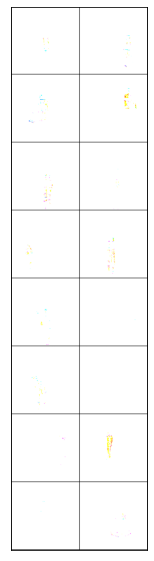

Train Epoch: 1 [150/40000 (2%)]	 Loss: 0.261889
Batch ID: 50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [300/40000 (4%)]	 Loss: 0.201113
Batch ID: 100


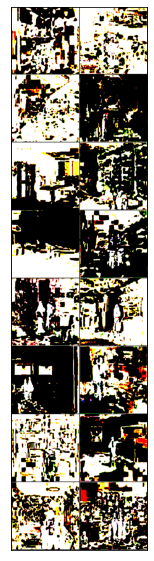

Train Epoch: 1 [450/40000 (6%)]	 Loss: 0.123132
Batch ID: 150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [600/40000 (8%)]	 Loss: 0.075522
Batch ID: 200


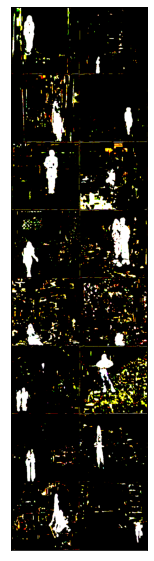

Train Epoch: 1 [750/40000 (10%)]	 Loss: 0.067279
Batch ID: 250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [900/40000 (12%)]	 Loss: 0.060178
Batch ID: 300


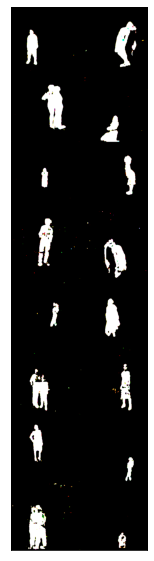

Train Epoch: 1 [1050/40000 (14%)]	 Loss: 0.042826
Batch ID: 350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [1200/40000 (16%)]	 Loss: 0.036800
Batch ID: 400


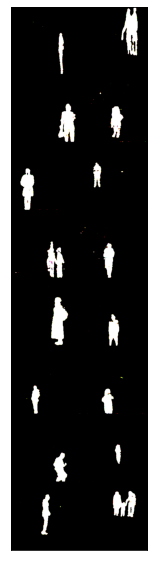

Train Epoch: 1 [1350/40000 (18%)]	 Loss: 0.053112
Batch ID: 450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [1500/40000 (20%)]	 Loss: 0.039613
Batch ID: 500


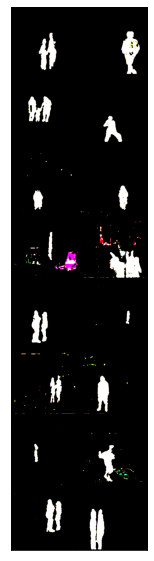

Train Epoch: 1 [1650/40000 (22%)]	 Loss: 0.034917
Batch ID: 550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [1800/40000 (24%)]	 Loss: 0.033580
Batch ID: 600


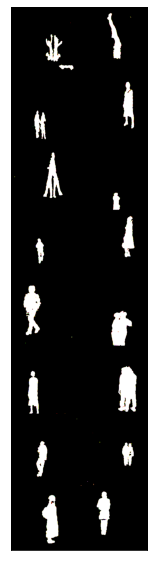

Train Epoch: 1 [1950/40000 (26%)]	 Loss: 0.031502
Batch ID: 650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [2100/40000 (28%)]	 Loss: 0.034925
Batch ID: 700


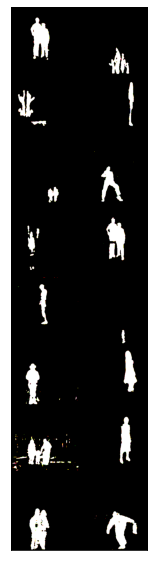

Train Epoch: 1 [2250/40000 (30%)]	 Loss: 0.040842
Batch ID: 750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [2400/40000 (32%)]	 Loss: 0.035751
Batch ID: 800


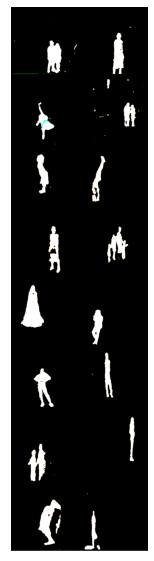

Train Epoch: 1 [2550/40000 (34%)]	 Loss: 0.029280
Batch ID: 850


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [2700/40000 (36%)]	 Loss: 0.030167
Batch ID: 900


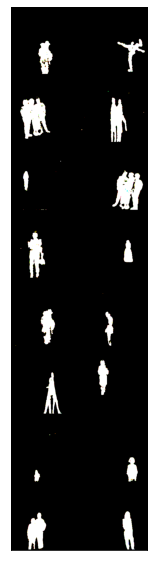

Train Epoch: 1 [2850/40000 (38%)]	 Loss: 0.028891
Batch ID: 950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [3000/40000 (40%)]	 Loss: 0.037118
Batch ID: 1000


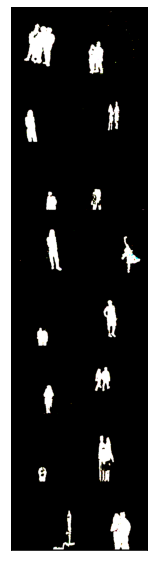

Train Epoch: 1 [3150/40000 (42%)]	 Loss: 0.024838
Batch ID: 1050


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [3300/40000 (44%)]	 Loss: 0.036562
Batch ID: 1100


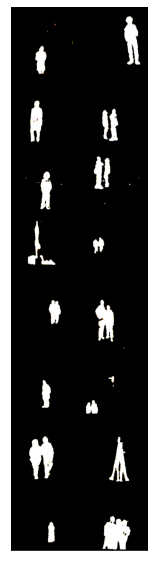

Train Epoch: 1 [3450/40000 (46%)]	 Loss: 0.023133
Batch ID: 1150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [3600/40000 (48%)]	 Loss: 0.026225
Batch ID: 1200


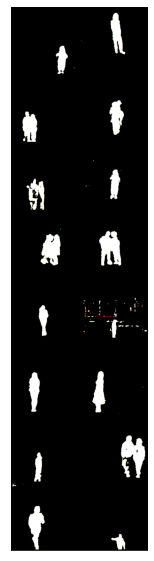

Train Epoch: 1 [3750/40000 (50%)]	 Loss: 0.033603
Batch ID: 1250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [3900/40000 (52%)]	 Loss: 0.023453
Batch ID: 1300


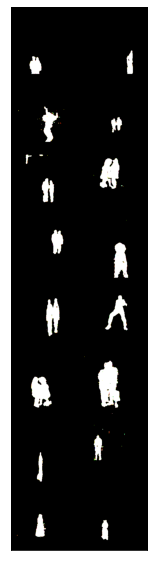

Train Epoch: 1 [4050/40000 (54%)]	 Loss: 0.029547
Batch ID: 1350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [4200/40000 (56%)]	 Loss: 0.020689
Batch ID: 1400


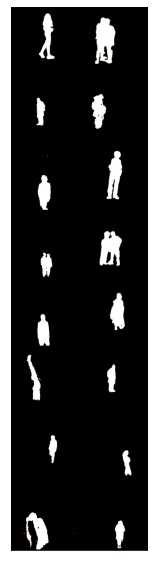

Train Epoch: 1 [4350/40000 (58%)]	 Loss: 0.029556
Batch ID: 1450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [4500/40000 (60%)]	 Loss: 0.029971
Batch ID: 1500


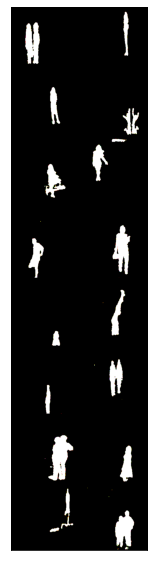

Train Epoch: 1 [4650/40000 (62%)]	 Loss: 0.022844
Batch ID: 1550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [4800/40000 (64%)]	 Loss: 0.032396
Batch ID: 1600


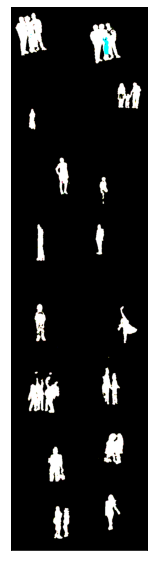

Train Epoch: 1 [4950/40000 (66%)]	 Loss: 0.027109
Batch ID: 1650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [5100/40000 (68%)]	 Loss: 0.028441
Batch ID: 1700


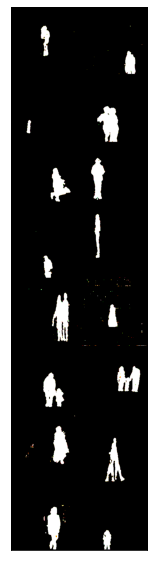

Train Epoch: 1 [5250/40000 (70%)]	 Loss: 0.021647
Batch ID: 1750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [5400/40000 (72%)]	 Loss: 0.031731
Batch ID: 1800


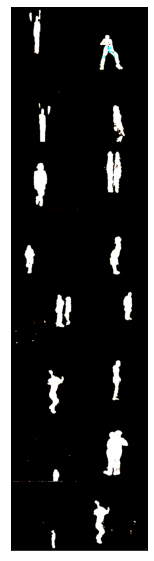

Train Epoch: 1 [5550/40000 (74%)]	 Loss: 0.033994
Batch ID: 1850


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [5700/40000 (76%)]	 Loss: 0.029550
Batch ID: 1900


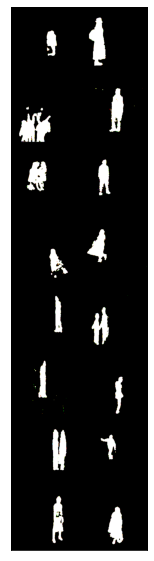

Train Epoch: 1 [5850/40000 (78%)]	 Loss: 0.024065
Batch ID: 1950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [6000/40000 (80%)]	 Loss: 0.021843
Batch ID: 2000


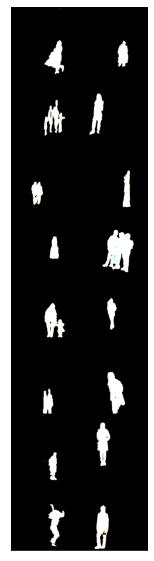

Train Epoch: 1 [6150/40000 (82%)]	 Loss: 0.018528
Batch ID: 2050


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [6300/40000 (84%)]	 Loss: 0.023713
Batch ID: 2100


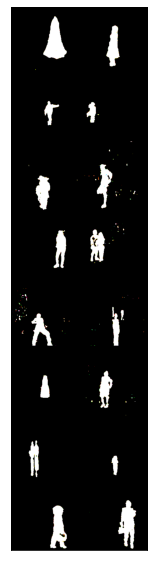

Train Epoch: 1 [6450/40000 (86%)]	 Loss: 0.024098
Batch ID: 2150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [6600/40000 (88%)]	 Loss: 0.020211
Batch ID: 2200


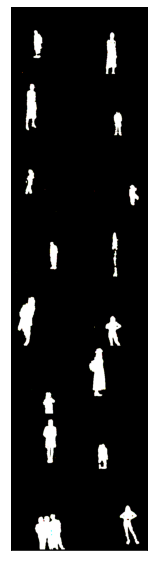

Train Epoch: 1 [6750/40000 (90%)]	 Loss: 0.026058
Batch ID: 2250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [6900/40000 (92%)]	 Loss: 0.027537
Batch ID: 2300


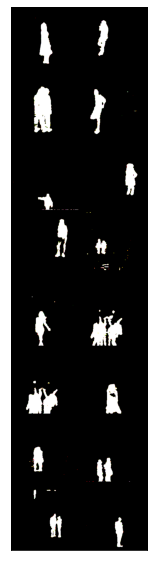

Train Epoch: 1 [7050/40000 (94%)]	 Loss: 0.024786
Batch ID: 2350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [7200/40000 (96%)]	 Loss: 0.023362
Batch ID: 2400


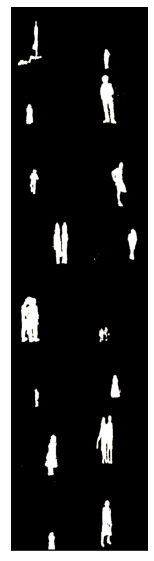

Train Epoch: 1 [7350/40000 (98%)]	 Loss: 0.027010
Batch ID: 2450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [0/40000 (0%)]	 Loss: 0.022712
Batch ID: 0


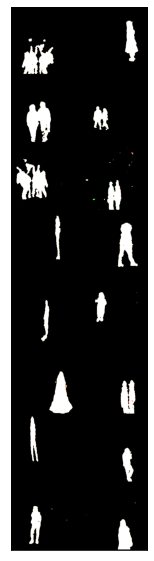

Train Epoch: 1 [150/40000 (2%)]	 Loss: 0.028128
Batch ID: 50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [300/40000 (4%)]	 Loss: 0.029532
Batch ID: 100


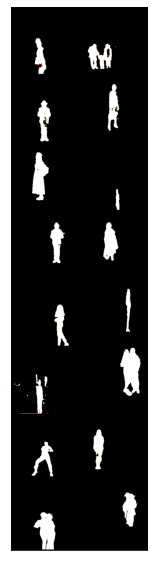

Train Epoch: 1 [450/40000 (6%)]	 Loss: 0.023350
Batch ID: 150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [600/40000 (8%)]	 Loss: 0.024574
Batch ID: 200


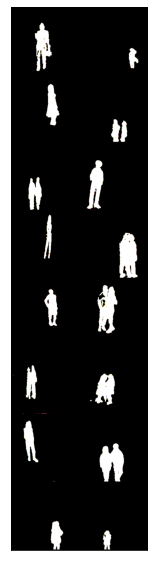

Train Epoch: 1 [750/40000 (10%)]	 Loss: 0.027441
Batch ID: 250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [900/40000 (12%)]	 Loss: 0.019056
Batch ID: 300


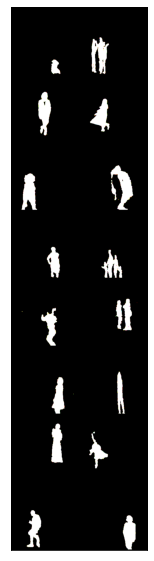

Train Epoch: 1 [1050/40000 (14%)]	 Loss: 0.020506
Batch ID: 350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [1200/40000 (16%)]	 Loss: 0.026100
Batch ID: 400


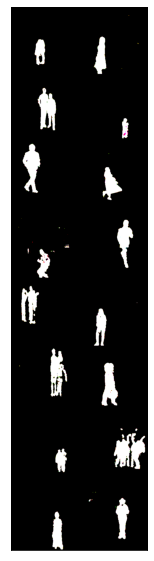

Train Epoch: 1 [1350/40000 (18%)]	 Loss: 0.031805
Batch ID: 450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [1500/40000 (20%)]	 Loss: 0.021701
Batch ID: 500


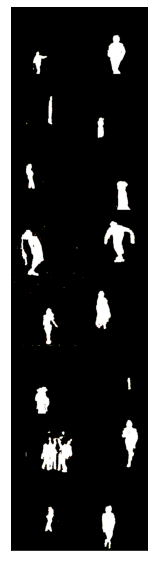

Train Epoch: 1 [1650/40000 (22%)]	 Loss: 0.018497
Batch ID: 550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [1800/40000 (24%)]	 Loss: 0.018461
Batch ID: 600


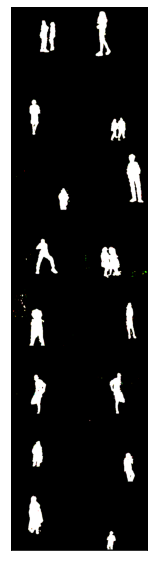

Train Epoch: 1 [1950/40000 (26%)]	 Loss: 0.025922
Batch ID: 650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [2100/40000 (28%)]	 Loss: 0.024295
Batch ID: 700


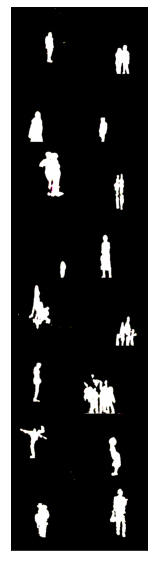

Train Epoch: 1 [2250/40000 (30%)]	 Loss: 0.019210
Batch ID: 750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [2400/40000 (32%)]	 Loss: 0.017065
Batch ID: 800


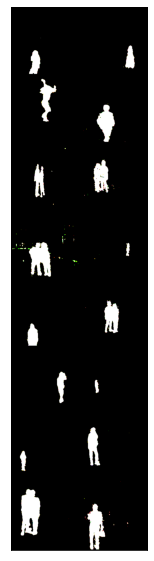

Train Epoch: 1 [2550/40000 (34%)]	 Loss: 0.018079
Batch ID: 850


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [2700/40000 (36%)]	 Loss: 0.021456
Batch ID: 900


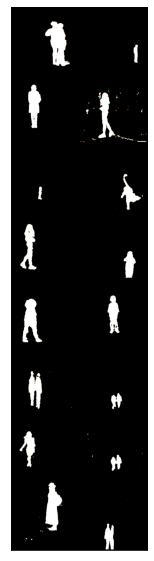

Train Epoch: 1 [2850/40000 (38%)]	 Loss: 0.020338
Batch ID: 950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [3000/40000 (40%)]	 Loss: 0.024651
Batch ID: 1000


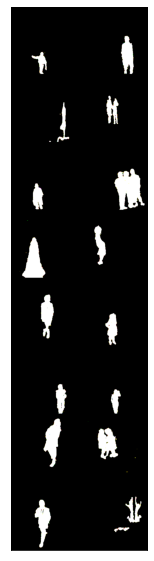

Train Epoch: 1 [3150/40000 (42%)]	 Loss: 0.020960
Batch ID: 1050


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [3300/40000 (44%)]	 Loss: 0.018147
Batch ID: 1100


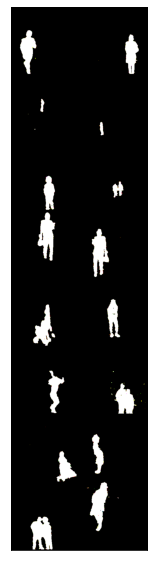

Train Epoch: 1 [3450/40000 (46%)]	 Loss: 0.022879
Batch ID: 1150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [3600/40000 (48%)]	 Loss: 0.026997
Batch ID: 1200


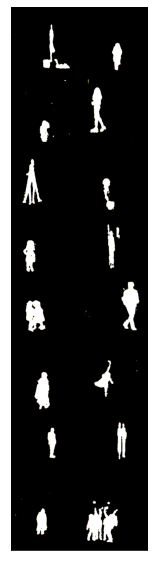

Train Epoch: 1 [3750/40000 (50%)]	 Loss: 0.019897
Batch ID: 1250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [3900/40000 (52%)]	 Loss: 0.024917
Batch ID: 1300


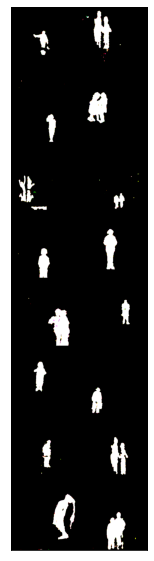

Train Epoch: 1 [4050/40000 (54%)]	 Loss: 0.020940
Batch ID: 1350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [4200/40000 (56%)]	 Loss: 0.028657
Batch ID: 1400


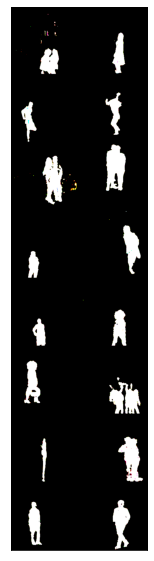

Train Epoch: 1 [4350/40000 (58%)]	 Loss: 0.028722
Batch ID: 1450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [4500/40000 (60%)]	 Loss: 0.021675
Batch ID: 1500


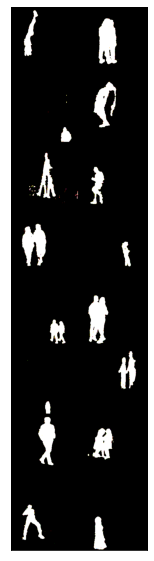

Train Epoch: 1 [4650/40000 (62%)]	 Loss: 0.020709
Batch ID: 1550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [4800/40000 (64%)]	 Loss: 0.024568
Batch ID: 1600


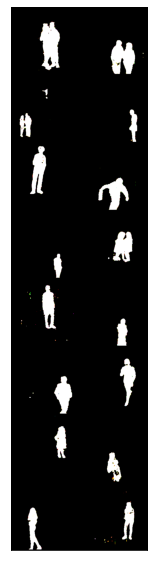

Train Epoch: 1 [4950/40000 (66%)]	 Loss: 0.024083
Batch ID: 1650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [5100/40000 (68%)]	 Loss: 0.020959
Batch ID: 1700


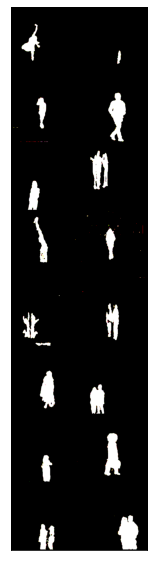

Train Epoch: 1 [5250/40000 (70%)]	 Loss: 0.017815
Batch ID: 1750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [5400/40000 (72%)]	 Loss: 0.021262
Batch ID: 1800


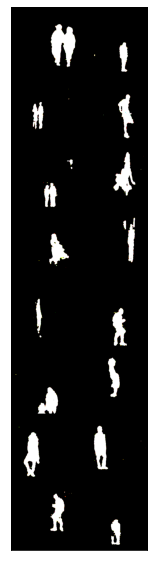

Train Epoch: 1 [5550/40000 (74%)]	 Loss: 0.026859
Batch ID: 1850


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [5700/40000 (76%)]	 Loss: 0.020698
Batch ID: 1900


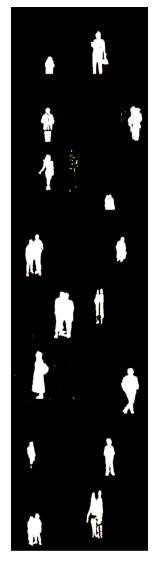

Train Epoch: 1 [5850/40000 (78%)]	 Loss: 0.018484
Batch ID: 1950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [6000/40000 (80%)]	 Loss: 0.018913
Batch ID: 2000


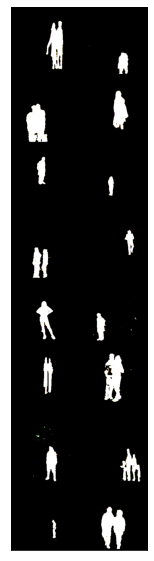

Train Epoch: 1 [6150/40000 (82%)]	 Loss: 0.022818
Batch ID: 2050


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [6300/40000 (84%)]	 Loss: 0.019648
Batch ID: 2100


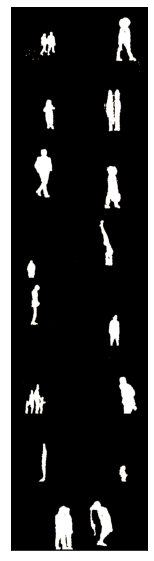

Train Epoch: 1 [6450/40000 (86%)]	 Loss: 0.019282
Batch ID: 2150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [6600/40000 (88%)]	 Loss: 0.018865
Batch ID: 2200


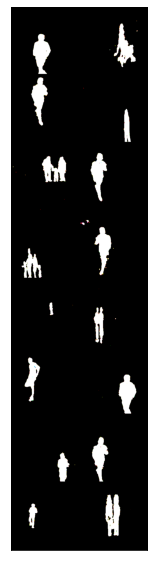

Train Epoch: 1 [6750/40000 (90%)]	 Loss: 0.026020
Batch ID: 2250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [6900/40000 (92%)]	 Loss: 0.021371
Batch ID: 2300


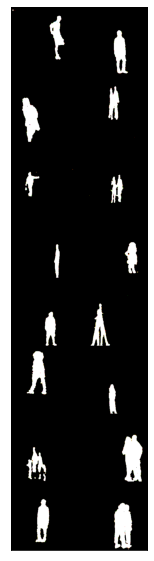

Train Epoch: 1 [7050/40000 (94%)]	 Loss: 0.018892
Batch ID: 2350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [7200/40000 (96%)]	 Loss: 0.021057
Batch ID: 2400


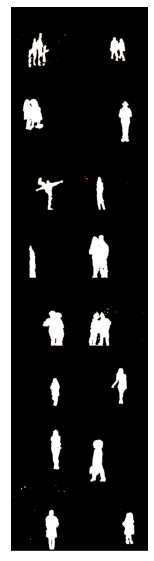

Train Epoch: 1 [7350/40000 (98%)]	 Loss: 0.020152
Batch ID: 2450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [0/40000 (0%)]	 Loss: 0.020798
Batch ID: 0


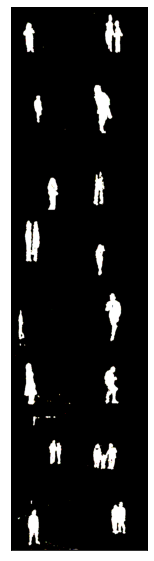

Train Epoch: 2 [150/40000 (2%)]	 Loss: 0.016456
Batch ID: 50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [300/40000 (4%)]	 Loss: 0.023092
Batch ID: 100


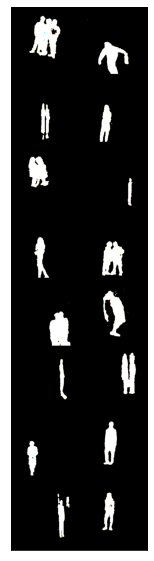

Train Epoch: 2 [450/40000 (6%)]	 Loss: 0.024955
Batch ID: 150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [600/40000 (8%)]	 Loss: 0.017856
Batch ID: 200


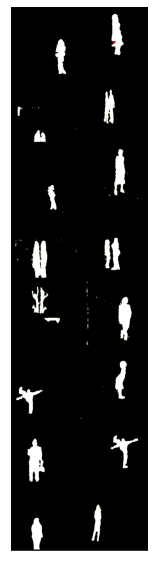

Train Epoch: 2 [750/40000 (10%)]	 Loss: 0.021045
Batch ID: 250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [900/40000 (12%)]	 Loss: 0.021331
Batch ID: 300


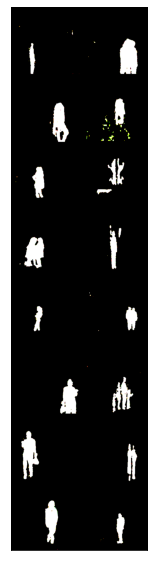

Train Epoch: 2 [1050/40000 (14%)]	 Loss: 0.023421
Batch ID: 350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [1200/40000 (16%)]	 Loss: 0.021655
Batch ID: 400


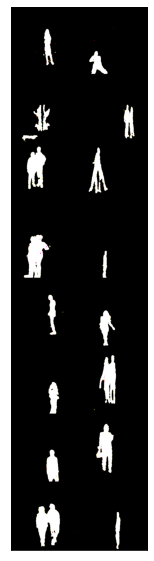

Train Epoch: 2 [1350/40000 (18%)]	 Loss: 0.020672
Batch ID: 450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [1500/40000 (20%)]	 Loss: 0.019197
Batch ID: 500


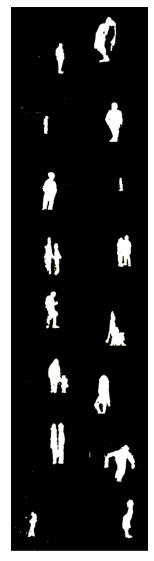

Train Epoch: 2 [1650/40000 (22%)]	 Loss: 0.021393
Batch ID: 550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [1800/40000 (24%)]	 Loss: 0.021563
Batch ID: 600


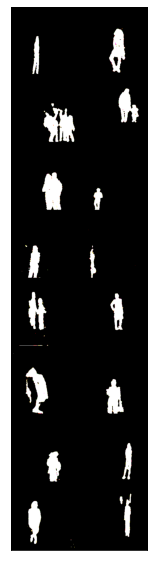

Train Epoch: 2 [1950/40000 (26%)]	 Loss: 0.017339
Batch ID: 650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [2100/40000 (28%)]	 Loss: 0.020274
Batch ID: 700


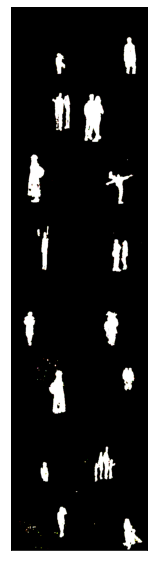

Train Epoch: 2 [2250/40000 (30%)]	 Loss: 0.018595
Batch ID: 750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [2400/40000 (32%)]	 Loss: 0.021449
Batch ID: 800


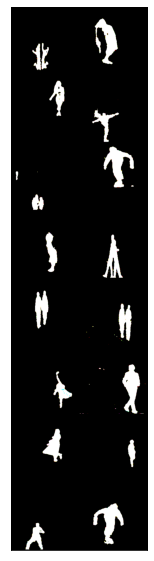

Train Epoch: 2 [2550/40000 (34%)]	 Loss: 0.021619
Batch ID: 850


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [2700/40000 (36%)]	 Loss: 0.021086
Batch ID: 900


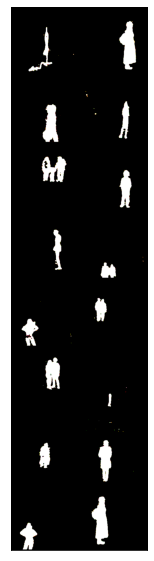

Train Epoch: 2 [2850/40000 (38%)]	 Loss: 0.025682
Batch ID: 950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [3000/40000 (40%)]	 Loss: 0.018876
Batch ID: 1000


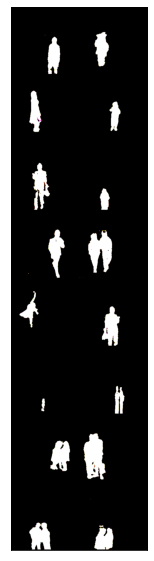

Train Epoch: 2 [3150/40000 (42%)]	 Loss: 0.023876
Batch ID: 1050


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [3300/40000 (44%)]	 Loss: 0.023768
Batch ID: 1100


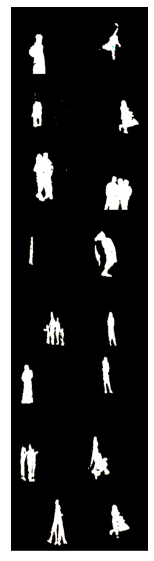

Train Epoch: 2 [3450/40000 (46%)]	 Loss: 0.020960
Batch ID: 1150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [3600/40000 (48%)]	 Loss: 0.018630
Batch ID: 1200


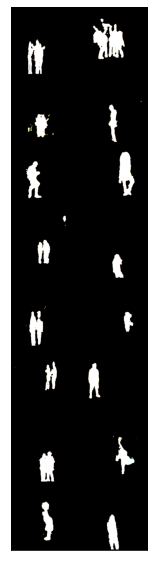

Train Epoch: 2 [3750/40000 (50%)]	 Loss: 0.023968
Batch ID: 1250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [3900/40000 (52%)]	 Loss: 0.021383
Batch ID: 1300


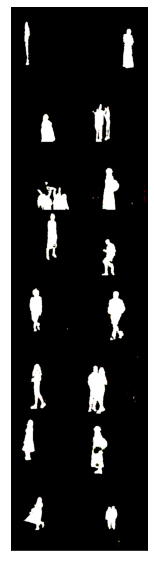

Train Epoch: 2 [4050/40000 (54%)]	 Loss: 0.021014
Batch ID: 1350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [4200/40000 (56%)]	 Loss: 0.021203
Batch ID: 1400


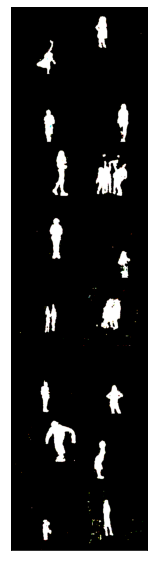

Train Epoch: 2 [4350/40000 (58%)]	 Loss: 0.019702
Batch ID: 1450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [4500/40000 (60%)]	 Loss: 0.027066
Batch ID: 1500


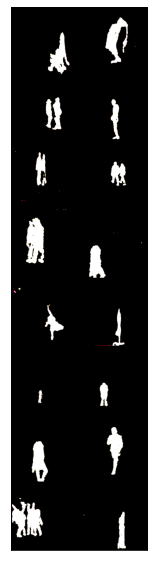

Train Epoch: 2 [4650/40000 (62%)]	 Loss: 0.022415
Batch ID: 1550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [4800/40000 (64%)]	 Loss: 0.021977
Batch ID: 1600


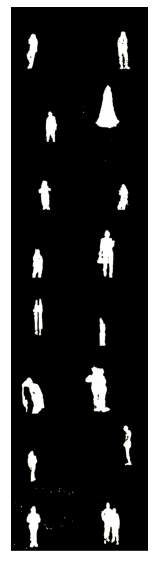

Train Epoch: 2 [4950/40000 (66%)]	 Loss: 0.021742
Batch ID: 1650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [5100/40000 (68%)]	 Loss: 0.022324
Batch ID: 1700


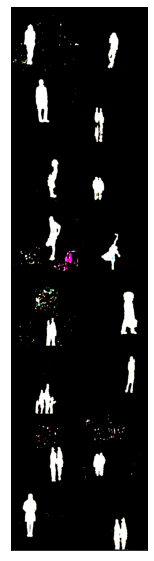

Train Epoch: 2 [5250/40000 (70%)]	 Loss: 0.017170
Batch ID: 1750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [5400/40000 (72%)]	 Loss: 0.022010
Batch ID: 1800


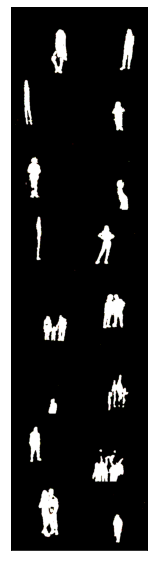

Train Epoch: 2 [5550/40000 (74%)]	 Loss: 0.021865
Batch ID: 1850


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [5700/40000 (76%)]	 Loss: 0.029310
Batch ID: 1900


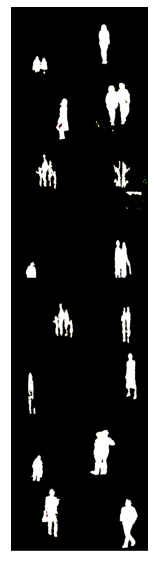

Train Epoch: 2 [5850/40000 (78%)]	 Loss: 0.017793
Batch ID: 1950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [6000/40000 (80%)]	 Loss: 0.014734
Batch ID: 2000


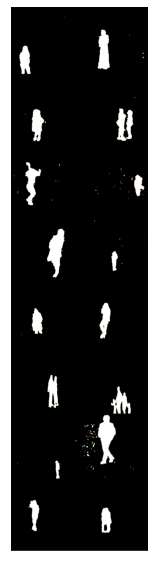

Train Epoch: 2 [6150/40000 (82%)]	 Loss: 0.021731
Batch ID: 2050


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [6300/40000 (84%)]	 Loss: 0.018367
Batch ID: 2100


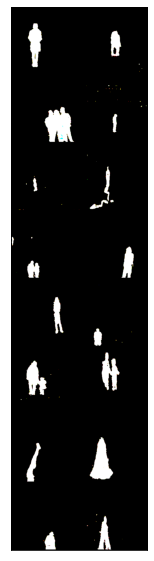

Train Epoch: 2 [6450/40000 (86%)]	 Loss: 0.022540
Batch ID: 2150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [6600/40000 (88%)]	 Loss: 0.020171
Batch ID: 2200


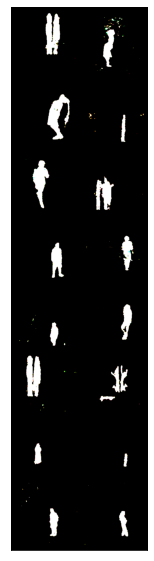

Train Epoch: 2 [6750/40000 (90%)]	 Loss: 0.024574
Batch ID: 2250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [6900/40000 (92%)]	 Loss: 0.019529
Batch ID: 2300


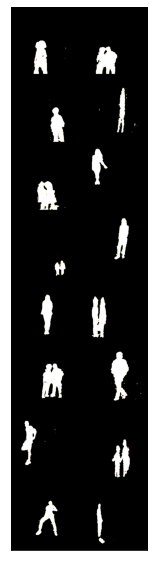

Train Epoch: 2 [7050/40000 (94%)]	 Loss: 0.017615
Batch ID: 2350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 2 [7200/40000 (96%)]	 Loss: 0.022302
Batch ID: 2400


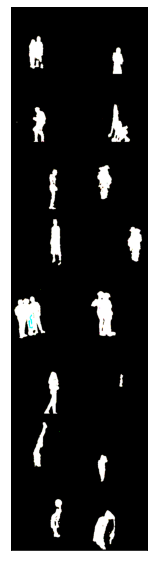

Train Epoch: 2 [7350/40000 (98%)]	 Loss: 0.023279
Batch ID: 2450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [0/40000 (0%)]	 Loss: 0.021401
Batch ID: 0


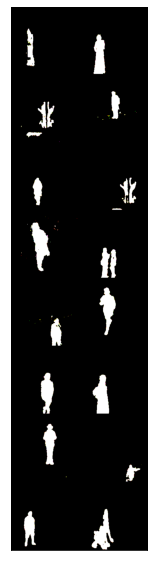

Train Epoch: 3 [150/40000 (2%)]	 Loss: 0.019518
Batch ID: 50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [300/40000 (4%)]	 Loss: 0.027224
Batch ID: 100


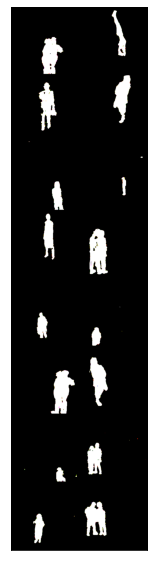

Train Epoch: 3 [450/40000 (6%)]	 Loss: 0.029505
Batch ID: 150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [600/40000 (8%)]	 Loss: 0.024301
Batch ID: 200


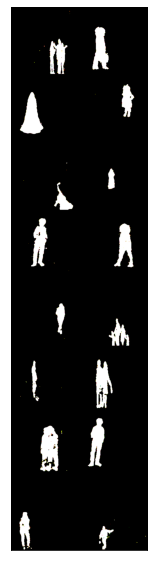

Train Epoch: 3 [750/40000 (10%)]	 Loss: 0.023611
Batch ID: 250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [900/40000 (12%)]	 Loss: 0.022349
Batch ID: 300


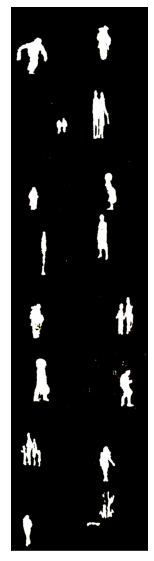

Train Epoch: 3 [1050/40000 (14%)]	 Loss: 0.015825
Batch ID: 350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [1200/40000 (16%)]	 Loss: 0.023678
Batch ID: 400


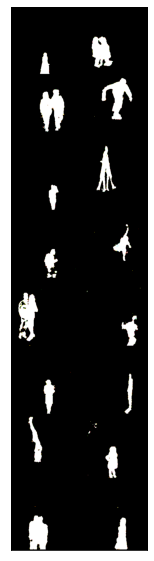

Train Epoch: 3 [1350/40000 (18%)]	 Loss: 0.016075
Batch ID: 450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [1500/40000 (20%)]	 Loss: 0.019227
Batch ID: 500


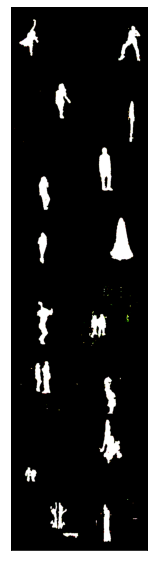

Train Epoch: 3 [1650/40000 (22%)]	 Loss: 0.016801
Batch ID: 550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [1800/40000 (24%)]	 Loss: 0.021833
Batch ID: 600


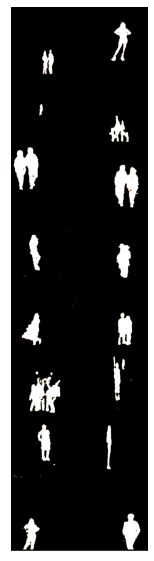

Train Epoch: 3 [1950/40000 (26%)]	 Loss: 0.016646
Batch ID: 650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [2100/40000 (28%)]	 Loss: 0.016510
Batch ID: 700


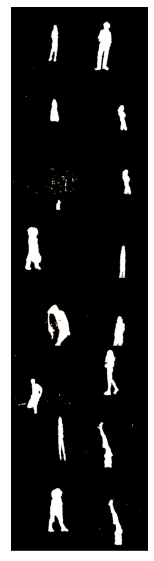

Train Epoch: 3 [2250/40000 (30%)]	 Loss: 0.022630
Batch ID: 750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [2400/40000 (32%)]	 Loss: 0.016905
Batch ID: 800


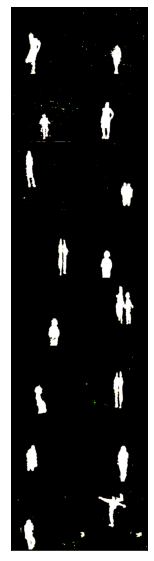

Train Epoch: 3 [2550/40000 (34%)]	 Loss: 0.016945
Batch ID: 850


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [2700/40000 (36%)]	 Loss: 0.017779
Batch ID: 900


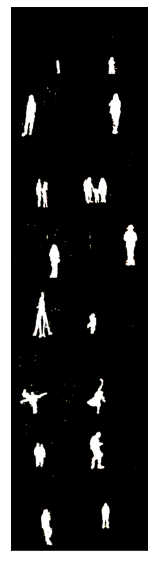

Train Epoch: 3 [2850/40000 (38%)]	 Loss: 0.021338
Batch ID: 950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [3000/40000 (40%)]	 Loss: 0.031902
Batch ID: 1000


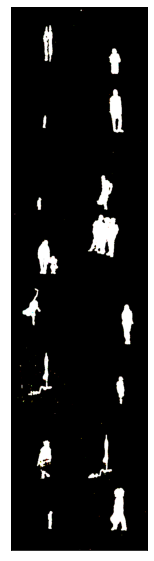

Train Epoch: 3 [3150/40000 (42%)]	 Loss: 0.019351
Batch ID: 1050


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [3300/40000 (44%)]	 Loss: 0.021049
Batch ID: 1100


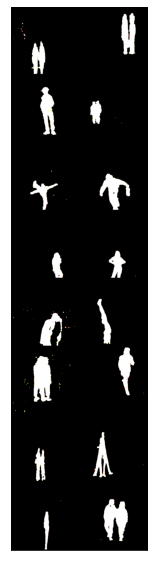

Train Epoch: 3 [3450/40000 (46%)]	 Loss: 0.021726
Batch ID: 1150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [3600/40000 (48%)]	 Loss: 0.020443
Batch ID: 1200


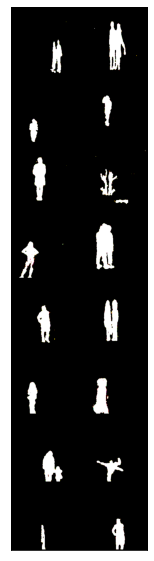

Train Epoch: 3 [3750/40000 (50%)]	 Loss: 0.015208
Batch ID: 1250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [3900/40000 (52%)]	 Loss: 0.021896
Batch ID: 1300


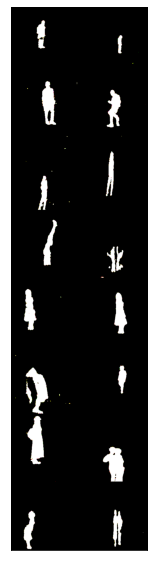

Train Epoch: 3 [4050/40000 (54%)]	 Loss: 0.018281
Batch ID: 1350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [4200/40000 (56%)]	 Loss: 0.024629
Batch ID: 1400


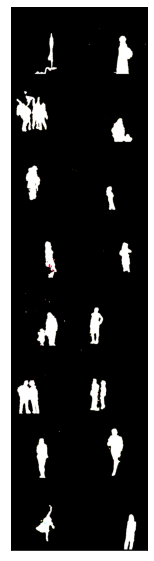

Train Epoch: 3 [4350/40000 (58%)]	 Loss: 0.024913
Batch ID: 1450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [4500/40000 (60%)]	 Loss: 0.019666
Batch ID: 1500


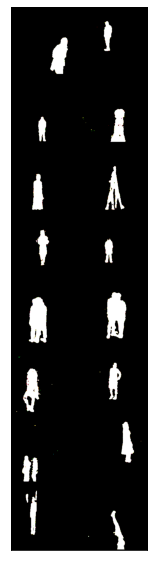

Train Epoch: 3 [4650/40000 (62%)]	 Loss: 0.022244
Batch ID: 1550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [4800/40000 (64%)]	 Loss: 0.019317
Batch ID: 1600


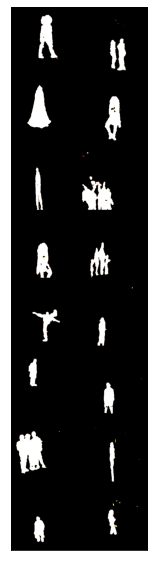

Train Epoch: 3 [4950/40000 (66%)]	 Loss: 0.020536
Batch ID: 1650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [5100/40000 (68%)]	 Loss: 0.019427
Batch ID: 1700


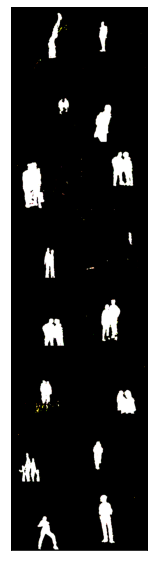

Train Epoch: 3 [5250/40000 (70%)]	 Loss: 0.019399
Batch ID: 1750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [5400/40000 (72%)]	 Loss: 0.019867
Batch ID: 1800


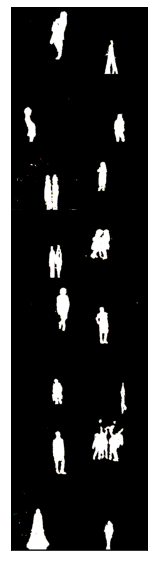

Train Epoch: 3 [5550/40000 (74%)]	 Loss: 0.023223
Batch ID: 1850


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [5700/40000 (76%)]	 Loss: 0.020307
Batch ID: 1900


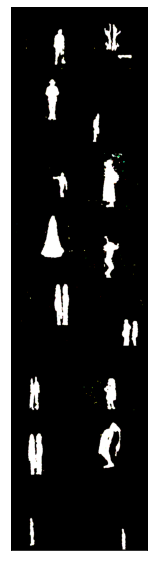

Train Epoch: 3 [5850/40000 (78%)]	 Loss: 0.028897
Batch ID: 1950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [6000/40000 (80%)]	 Loss: 0.017588
Batch ID: 2000


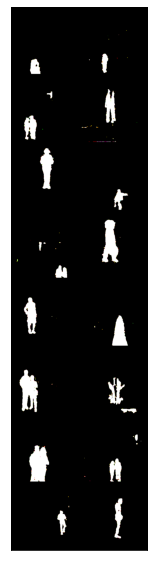

Train Epoch: 3 [6150/40000 (82%)]	 Loss: 0.020597
Batch ID: 2050


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [6300/40000 (84%)]	 Loss: 0.022208
Batch ID: 2100


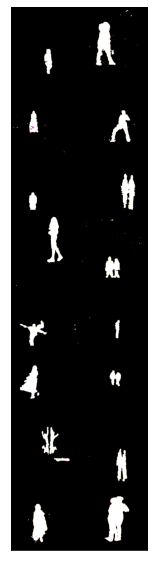

Train Epoch: 3 [6450/40000 (86%)]	 Loss: 0.021822
Batch ID: 2150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [6600/40000 (88%)]	 Loss: 0.019514
Batch ID: 2200


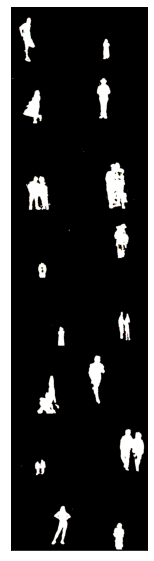

Train Epoch: 3 [6750/40000 (90%)]	 Loss: 0.021712
Batch ID: 2250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [6900/40000 (92%)]	 Loss: 0.029244
Batch ID: 2300


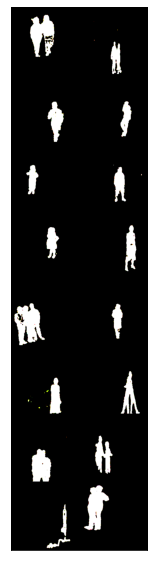

Train Epoch: 3 [7050/40000 (94%)]	 Loss: 0.016897
Batch ID: 2350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 3 [7200/40000 (96%)]	 Loss: 0.021393
Batch ID: 2400


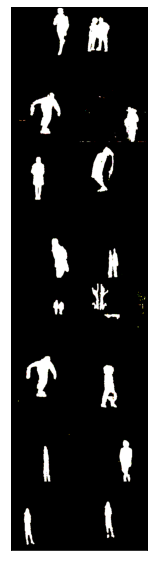

Train Epoch: 3 [7350/40000 (98%)]	 Loss: 0.022505
Batch ID: 2450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [0/40000 (0%)]	 Loss: 0.030187
Batch ID: 0


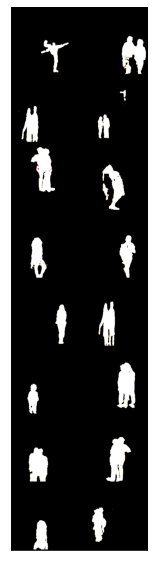

Train Epoch: 4 [150/40000 (2%)]	 Loss: 0.024869
Batch ID: 50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [300/40000 (4%)]	 Loss: 0.020940
Batch ID: 100


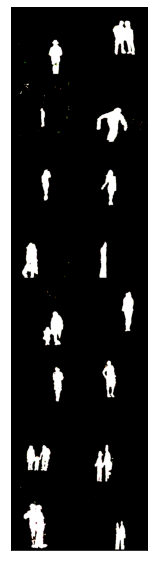

Train Epoch: 4 [450/40000 (6%)]	 Loss: 0.017631
Batch ID: 150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [600/40000 (8%)]	 Loss: 0.018196
Batch ID: 200


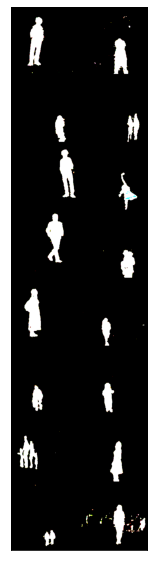

Train Epoch: 4 [750/40000 (10%)]	 Loss: 0.020973
Batch ID: 250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [900/40000 (12%)]	 Loss: 0.017231
Batch ID: 300


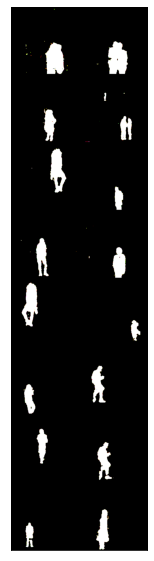

Train Epoch: 4 [1050/40000 (14%)]	 Loss: 0.015467
Batch ID: 350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [1200/40000 (16%)]	 Loss: 0.022804
Batch ID: 400


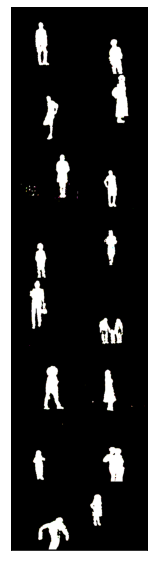

Train Epoch: 4 [1350/40000 (18%)]	 Loss: 0.027980
Batch ID: 450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [1500/40000 (20%)]	 Loss: 0.022338
Batch ID: 500


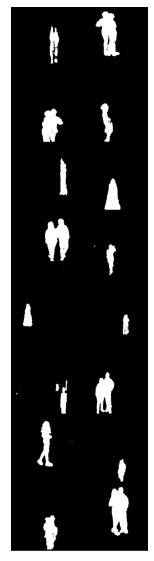

Train Epoch: 4 [1650/40000 (22%)]	 Loss: 0.020566
Batch ID: 550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [1800/40000 (24%)]	 Loss: 0.030591
Batch ID: 600


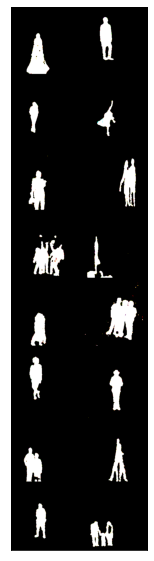

Train Epoch: 4 [1950/40000 (26%)]	 Loss: 0.019761
Batch ID: 650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [2100/40000 (28%)]	 Loss: 0.016487
Batch ID: 700


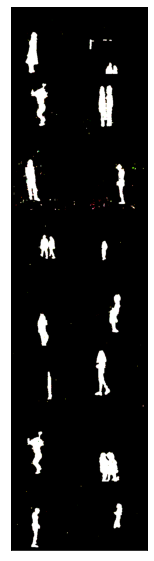

Train Epoch: 4 [2250/40000 (30%)]	 Loss: 0.020595
Batch ID: 750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [2400/40000 (32%)]	 Loss: 0.021252
Batch ID: 800


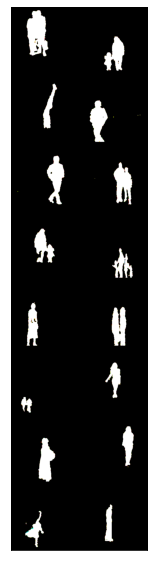

Train Epoch: 4 [2550/40000 (34%)]	 Loss: 0.024088
Batch ID: 850


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [2700/40000 (36%)]	 Loss: 0.017854
Batch ID: 900


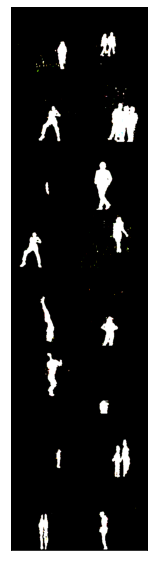

Train Epoch: 4 [2850/40000 (38%)]	 Loss: 0.019540
Batch ID: 950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [3000/40000 (40%)]	 Loss: 0.024368
Batch ID: 1000


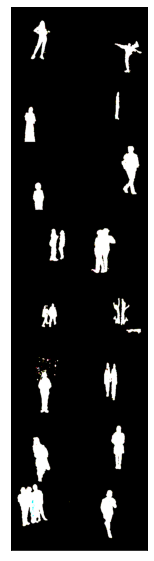

Train Epoch: 4 [3150/40000 (42%)]	 Loss: 0.022349
Batch ID: 1050


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [3300/40000 (44%)]	 Loss: 0.020752
Batch ID: 1100


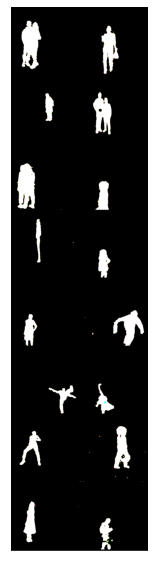

Train Epoch: 4 [3450/40000 (46%)]	 Loss: 0.019664
Batch ID: 1150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [3600/40000 (48%)]	 Loss: 0.025104
Batch ID: 1200


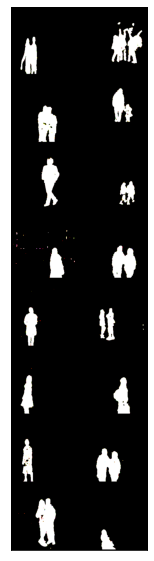

Train Epoch: 4 [3750/40000 (50%)]	 Loss: 0.017773
Batch ID: 1250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [3900/40000 (52%)]	 Loss: 0.021135
Batch ID: 1300


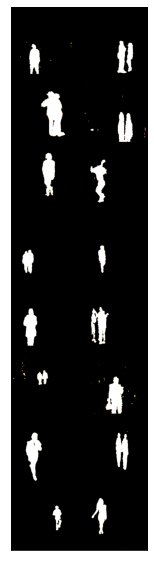

Train Epoch: 4 [4050/40000 (54%)]	 Loss: 0.020517
Batch ID: 1350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [4200/40000 (56%)]	 Loss: 0.023596
Batch ID: 1400


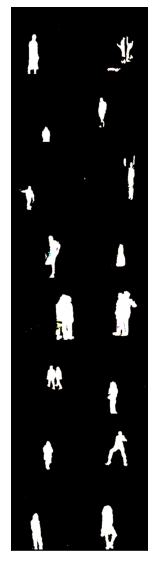

Train Epoch: 4 [4350/40000 (58%)]	 Loss: 0.024881
Batch ID: 1450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [4500/40000 (60%)]	 Loss: 0.026387
Batch ID: 1500


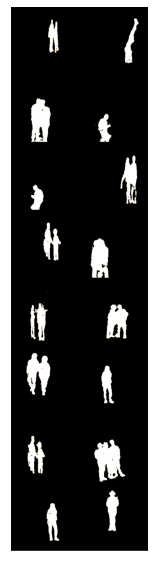

Train Epoch: 4 [4650/40000 (62%)]	 Loss: 0.017576
Batch ID: 1550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [4800/40000 (64%)]	 Loss: 0.015252
Batch ID: 1600


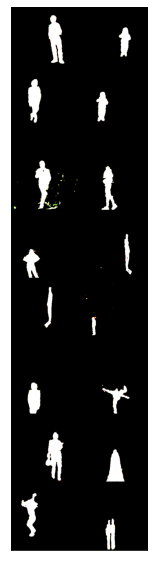

Train Epoch: 4 [4950/40000 (66%)]	 Loss: 0.019384
Batch ID: 1650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [5100/40000 (68%)]	 Loss: 0.016073
Batch ID: 1700


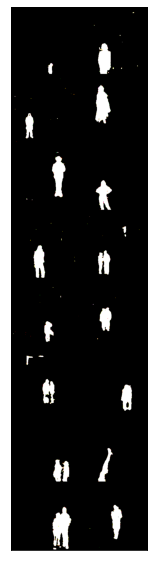

Train Epoch: 4 [5250/40000 (70%)]	 Loss: 0.020573
Batch ID: 1750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [5400/40000 (72%)]	 Loss: 0.018946
Batch ID: 1800


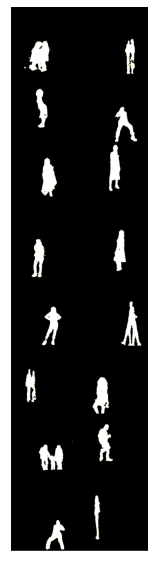

Train Epoch: 4 [5550/40000 (74%)]	 Loss: 0.020079
Batch ID: 1850


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [5700/40000 (76%)]	 Loss: 0.017317
Batch ID: 1900


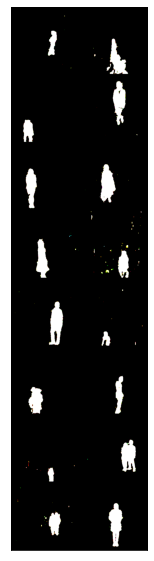

Train Epoch: 4 [5850/40000 (78%)]	 Loss: 0.019693
Batch ID: 1950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [6000/40000 (80%)]	 Loss: 0.015969
Batch ID: 2000


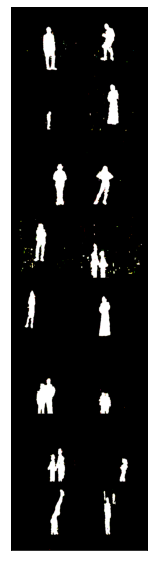

Train Epoch: 4 [6150/40000 (82%)]	 Loss: 0.020605
Batch ID: 2050


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [6300/40000 (84%)]	 Loss: 0.020969
Batch ID: 2100


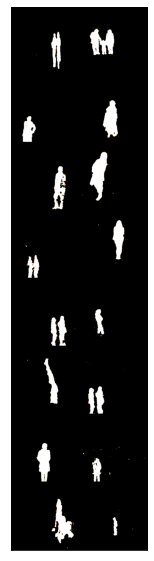

Train Epoch: 4 [6450/40000 (86%)]	 Loss: 0.019824
Batch ID: 2150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [6600/40000 (88%)]	 Loss: 0.025246
Batch ID: 2200


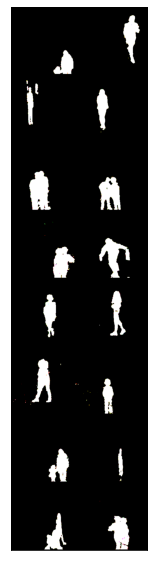

Train Epoch: 4 [6750/40000 (90%)]	 Loss: 0.018491
Batch ID: 2250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [6900/40000 (92%)]	 Loss: 0.021372
Batch ID: 2300


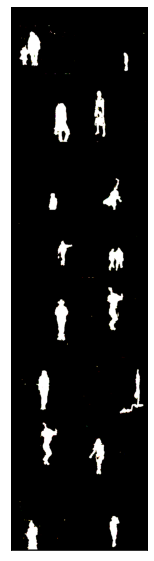

Train Epoch: 4 [7050/40000 (94%)]	 Loss: 0.021243
Batch ID: 2350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 4 [7200/40000 (96%)]	 Loss: 0.027170
Batch ID: 2400


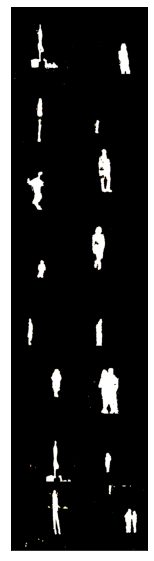

Train Epoch: 4 [7350/40000 (98%)]	 Loss: 0.021840
Batch ID: 2450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [0/40000 (0%)]	 Loss: 0.022845
Batch ID: 0


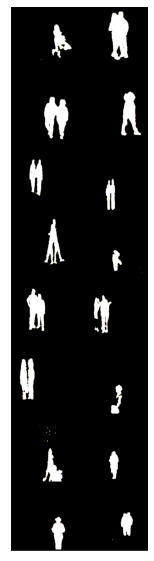

Train Epoch: 5 [150/40000 (2%)]	 Loss: 0.022281
Batch ID: 50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [300/40000 (4%)]	 Loss: 0.020091
Batch ID: 100


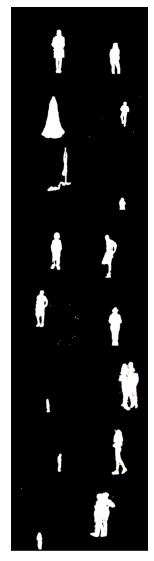

Train Epoch: 5 [450/40000 (6%)]	 Loss: 0.016994
Batch ID: 150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [600/40000 (8%)]	 Loss: 0.019297
Batch ID: 200


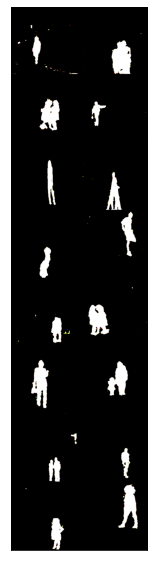

Train Epoch: 5 [750/40000 (10%)]	 Loss: 0.016633
Batch ID: 250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [900/40000 (12%)]	 Loss: 0.026015
Batch ID: 300


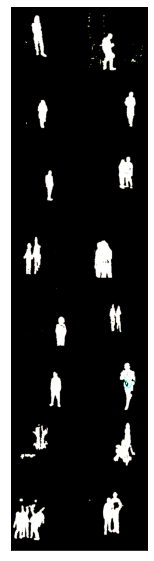

Train Epoch: 5 [1050/40000 (14%)]	 Loss: 0.021576
Batch ID: 350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [1200/40000 (16%)]	 Loss: 0.024080
Batch ID: 400


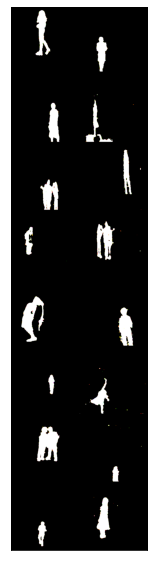

Train Epoch: 5 [1350/40000 (18%)]	 Loss: 0.020468
Batch ID: 450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [1500/40000 (20%)]	 Loss: 0.017655
Batch ID: 500


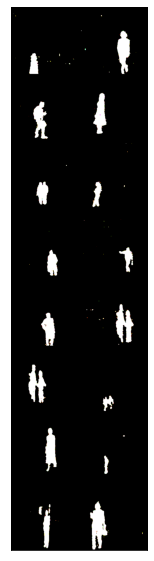

Train Epoch: 5 [1650/40000 (22%)]	 Loss: 0.016281
Batch ID: 550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [1800/40000 (24%)]	 Loss: 0.021941
Batch ID: 600


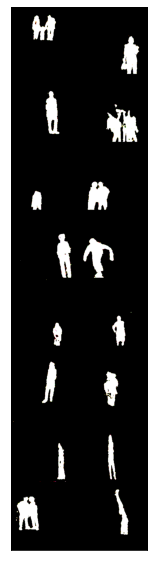

Train Epoch: 5 [1950/40000 (26%)]	 Loss: 0.027255
Batch ID: 650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [2100/40000 (28%)]	 Loss: 0.020100
Batch ID: 700


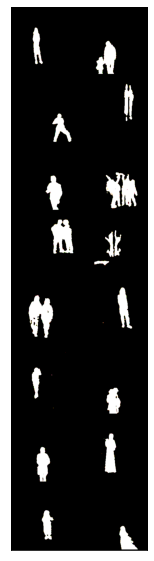

Train Epoch: 5 [2250/40000 (30%)]	 Loss: 0.021898
Batch ID: 750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [2400/40000 (32%)]	 Loss: 0.028327
Batch ID: 800


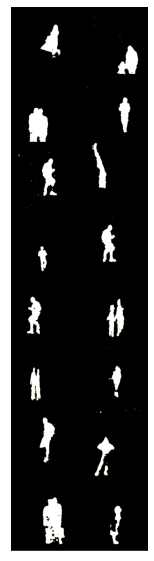

Train Epoch: 5 [2550/40000 (34%)]	 Loss: 0.015051
Batch ID: 850


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [2700/40000 (36%)]	 Loss: 0.029616
Batch ID: 900


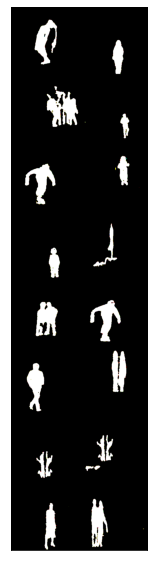

Train Epoch: 5 [2850/40000 (38%)]	 Loss: 0.018021
Batch ID: 950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [3000/40000 (40%)]	 Loss: 0.018187
Batch ID: 1000


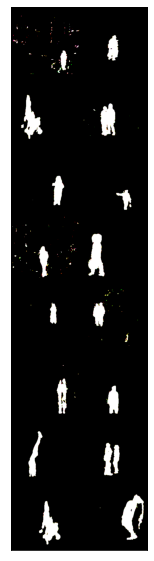

Train Epoch: 5 [3150/40000 (42%)]	 Loss: 0.023822
Batch ID: 1050


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [3300/40000 (44%)]	 Loss: 0.021696
Batch ID: 1100


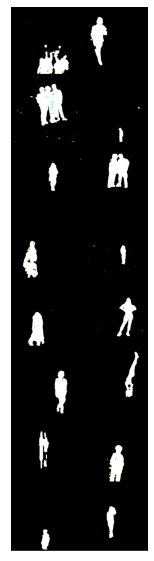

Train Epoch: 5 [3450/40000 (46%)]	 Loss: 0.026117
Batch ID: 1150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [3600/40000 (48%)]	 Loss: 0.018577
Batch ID: 1200


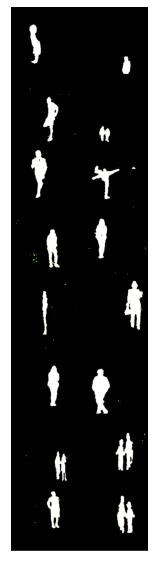

Train Epoch: 5 [3750/40000 (50%)]	 Loss: 0.019365
Batch ID: 1250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [3900/40000 (52%)]	 Loss: 0.020520
Batch ID: 1300


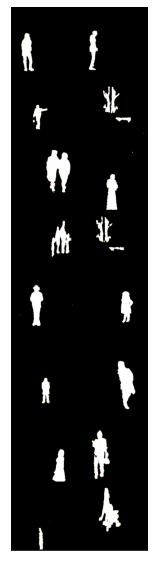

Train Epoch: 5 [4050/40000 (54%)]	 Loss: 0.019644
Batch ID: 1350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [4200/40000 (56%)]	 Loss: 0.019756
Batch ID: 1400


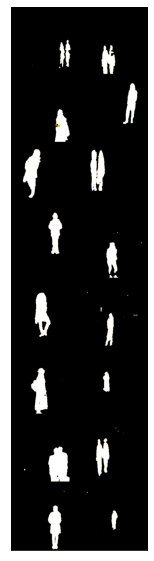

Train Epoch: 5 [4350/40000 (58%)]	 Loss: 0.020814
Batch ID: 1450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [4500/40000 (60%)]	 Loss: 0.018439
Batch ID: 1500


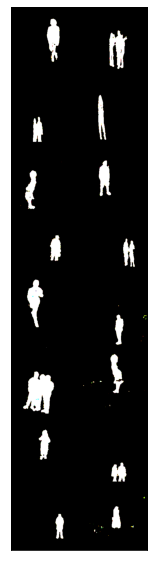

Train Epoch: 5 [4650/40000 (62%)]	 Loss: 0.019710
Batch ID: 1550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [4800/40000 (64%)]	 Loss: 0.019302
Batch ID: 1600


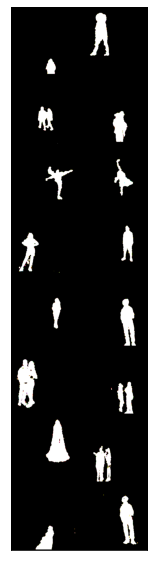

Train Epoch: 5 [4950/40000 (66%)]	 Loss: 0.022048
Batch ID: 1650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [5100/40000 (68%)]	 Loss: 0.022165
Batch ID: 1700


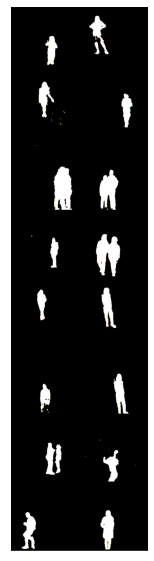

Train Epoch: 5 [5250/40000 (70%)]	 Loss: 0.018167
Batch ID: 1750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [5400/40000 (72%)]	 Loss: 0.020792
Batch ID: 1800


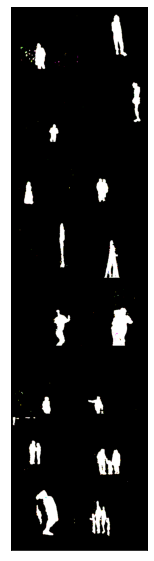

Train Epoch: 5 [5550/40000 (74%)]	 Loss: 0.020886
Batch ID: 1850


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [5700/40000 (76%)]	 Loss: 0.028886
Batch ID: 1900


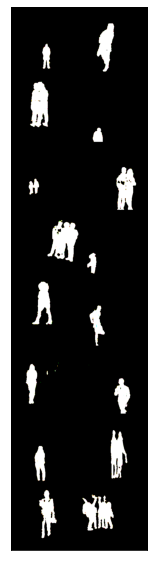

Train Epoch: 5 [5850/40000 (78%)]	 Loss: 0.017973
Batch ID: 1950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [6000/40000 (80%)]	 Loss: 0.019223
Batch ID: 2000


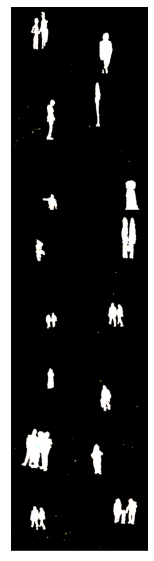

Train Epoch: 5 [6150/40000 (82%)]	 Loss: 0.021370
Batch ID: 2050


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [6300/40000 (84%)]	 Loss: 0.018725
Batch ID: 2100


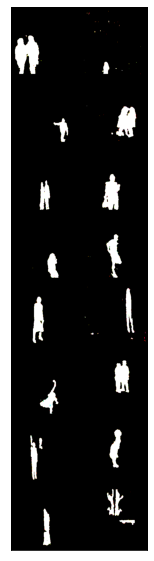

Train Epoch: 5 [6450/40000 (86%)]	 Loss: 0.015341
Batch ID: 2150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [6600/40000 (88%)]	 Loss: 0.018878
Batch ID: 2200


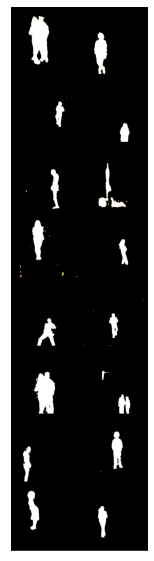

Train Epoch: 5 [6750/40000 (90%)]	 Loss: 0.016509
Batch ID: 2250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [6900/40000 (92%)]	 Loss: 0.023197
Batch ID: 2300


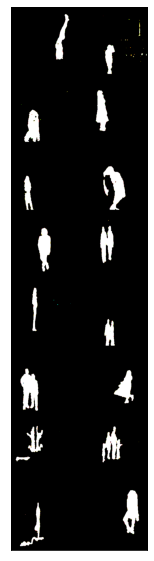

Train Epoch: 5 [7050/40000 (94%)]	 Loss: 0.029599
Batch ID: 2350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 5 [7200/40000 (96%)]	 Loss: 0.019020
Batch ID: 2400


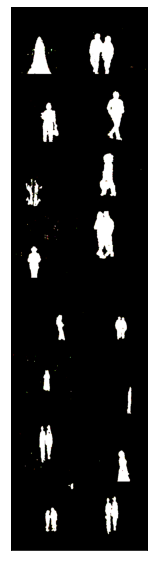

Train Epoch: 5 [7350/40000 (98%)]	 Loss: 0.020962
Batch ID: 2450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [0/40000 (0%)]	 Loss: 0.019446
Batch ID: 0


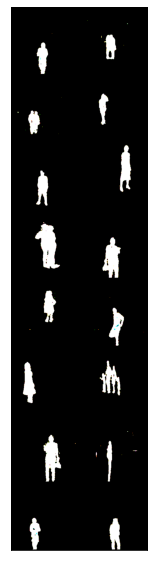

Train Epoch: 6 [150/40000 (2%)]	 Loss: 0.018536
Batch ID: 50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [300/40000 (4%)]	 Loss: 0.019868
Batch ID: 100


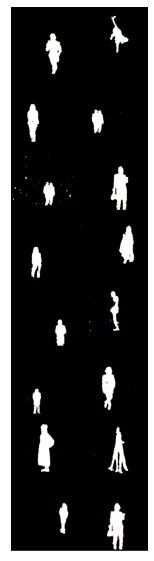

Train Epoch: 6 [450/40000 (6%)]	 Loss: 0.015899
Batch ID: 150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [600/40000 (8%)]	 Loss: 0.016527
Batch ID: 200


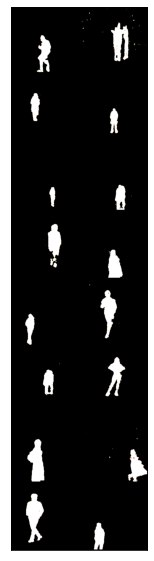

Train Epoch: 6 [750/40000 (10%)]	 Loss: 0.017935
Batch ID: 250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [900/40000 (12%)]	 Loss: 0.020164
Batch ID: 300


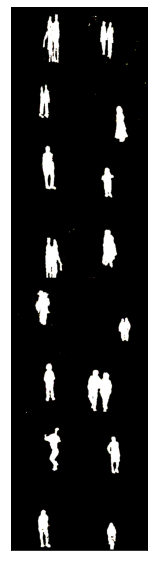

Train Epoch: 6 [1050/40000 (14%)]	 Loss: 0.015843
Batch ID: 350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [1200/40000 (16%)]	 Loss: 0.021053
Batch ID: 400


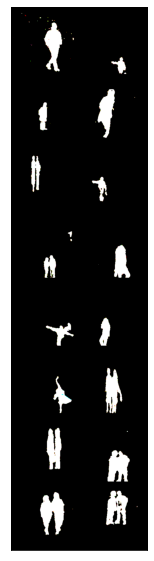

Train Epoch: 6 [1350/40000 (18%)]	 Loss: 0.018421
Batch ID: 450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [1500/40000 (20%)]	 Loss: 0.018476
Batch ID: 500


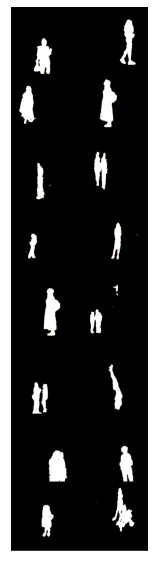

Train Epoch: 6 [1650/40000 (22%)]	 Loss: 0.023080
Batch ID: 550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [1800/40000 (24%)]	 Loss: 0.019259
Batch ID: 600


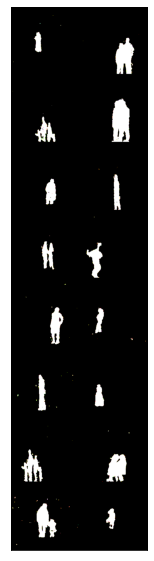

Train Epoch: 6 [1950/40000 (26%)]	 Loss: 0.018395
Batch ID: 650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [2100/40000 (28%)]	 Loss: 0.017865
Batch ID: 700


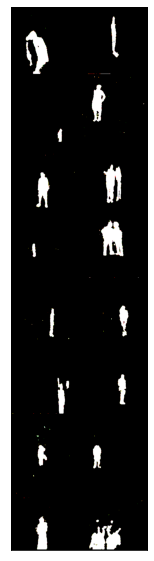

Train Epoch: 6 [2250/40000 (30%)]	 Loss: 0.021237
Batch ID: 750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [2400/40000 (32%)]	 Loss: 0.017661
Batch ID: 800


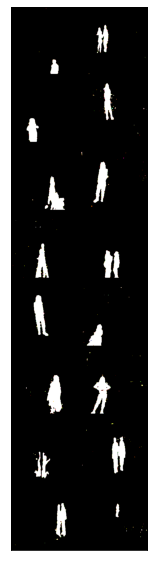

Train Epoch: 6 [2550/40000 (34%)]	 Loss: 0.020081
Batch ID: 850


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [2700/40000 (36%)]	 Loss: 0.016317
Batch ID: 900


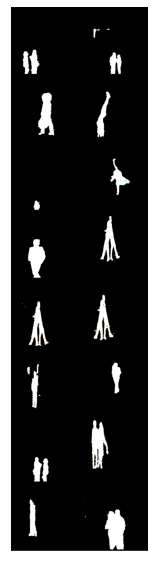

Train Epoch: 6 [2850/40000 (38%)]	 Loss: 0.019290
Batch ID: 950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [3000/40000 (40%)]	 Loss: 0.022092
Batch ID: 1000


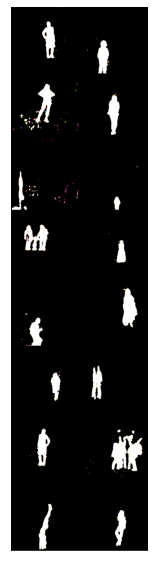

Train Epoch: 6 [3150/40000 (42%)]	 Loss: 0.027098
Batch ID: 1050


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [3300/40000 (44%)]	 Loss: 0.017321
Batch ID: 1100


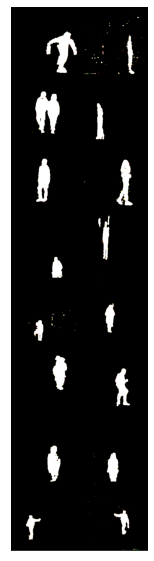

Train Epoch: 6 [3450/40000 (46%)]	 Loss: 0.022148
Batch ID: 1150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [3600/40000 (48%)]	 Loss: 0.019835
Batch ID: 1200


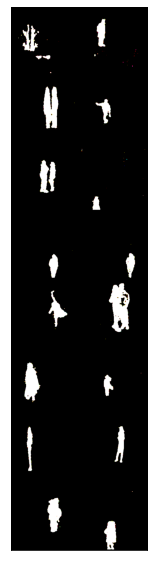

Train Epoch: 6 [3750/40000 (50%)]	 Loss: 0.022618
Batch ID: 1250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [3900/40000 (52%)]	 Loss: 0.020201
Batch ID: 1300


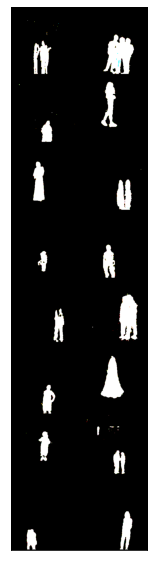

Train Epoch: 6 [4050/40000 (54%)]	 Loss: 0.018508
Batch ID: 1350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [4200/40000 (56%)]	 Loss: 0.025757
Batch ID: 1400


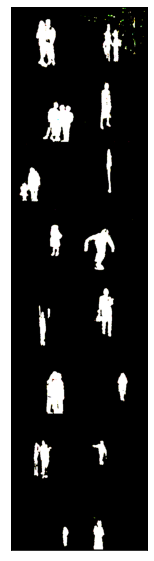

Train Epoch: 6 [4350/40000 (58%)]	 Loss: 0.016203
Batch ID: 1450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [4500/40000 (60%)]	 Loss: 0.021304
Batch ID: 1500


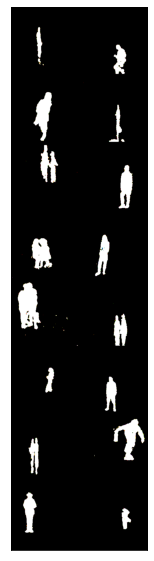

Train Epoch: 6 [4650/40000 (62%)]	 Loss: 0.016951
Batch ID: 1550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [4800/40000 (64%)]	 Loss: 0.018640
Batch ID: 1600


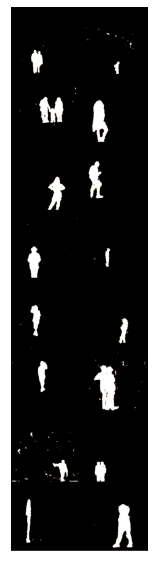

Train Epoch: 6 [4950/40000 (66%)]	 Loss: 0.025814
Batch ID: 1650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [5100/40000 (68%)]	 Loss: 0.019672
Batch ID: 1700


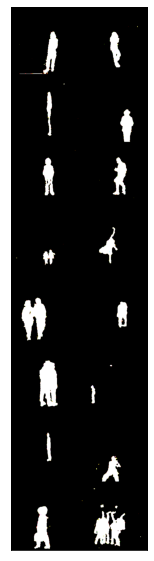

Train Epoch: 6 [5250/40000 (70%)]	 Loss: 0.017472
Batch ID: 1750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [5400/40000 (72%)]	 Loss: 0.019320
Batch ID: 1800


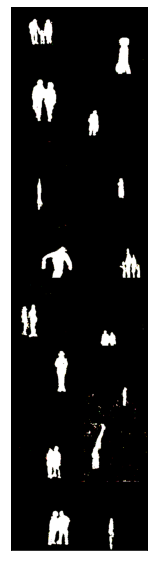

Train Epoch: 6 [5550/40000 (74%)]	 Loss: 0.022255
Batch ID: 1850


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [5700/40000 (76%)]	 Loss: 0.014770
Batch ID: 1900


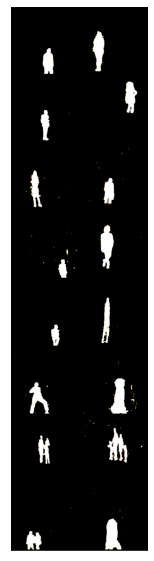

Train Epoch: 6 [5850/40000 (78%)]	 Loss: 0.017736
Batch ID: 1950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [6000/40000 (80%)]	 Loss: 0.016256
Batch ID: 2000


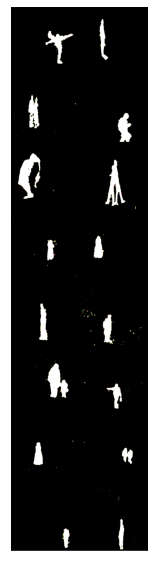

Train Epoch: 6 [6150/40000 (82%)]	 Loss: 0.020865
Batch ID: 2050


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [6300/40000 (84%)]	 Loss: 0.024613
Batch ID: 2100


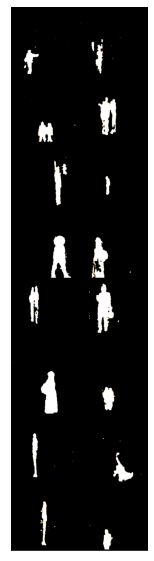

Train Epoch: 6 [6450/40000 (86%)]	 Loss: 0.023459
Batch ID: 2150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [6600/40000 (88%)]	 Loss: 0.021847
Batch ID: 2200


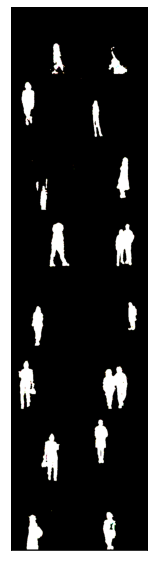

Train Epoch: 6 [6750/40000 (90%)]	 Loss: 0.020190
Batch ID: 2250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [6900/40000 (92%)]	 Loss: 0.018260
Batch ID: 2300


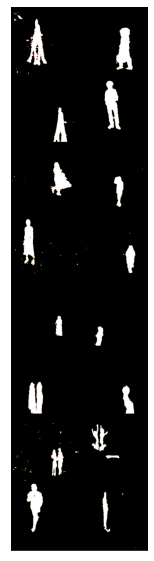

Train Epoch: 6 [7050/40000 (94%)]	 Loss: 0.017022
Batch ID: 2350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 6 [7200/40000 (96%)]	 Loss: 0.019041
Batch ID: 2400


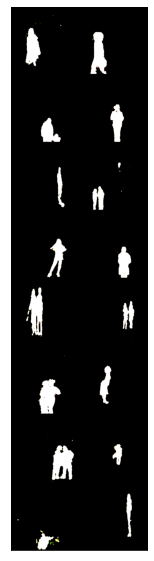

Train Epoch: 6 [7350/40000 (98%)]	 Loss: 0.021190
Batch ID: 2450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [0/40000 (0%)]	 Loss: 0.025232
Batch ID: 0


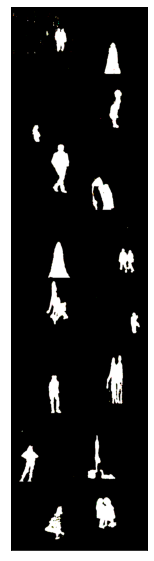

Train Epoch: 7 [150/40000 (2%)]	 Loss: 0.022150
Batch ID: 50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [300/40000 (4%)]	 Loss: 0.017151
Batch ID: 100


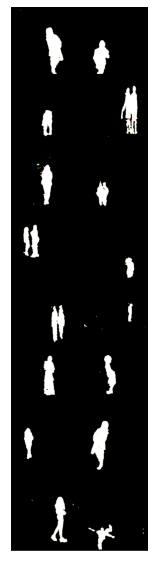

Train Epoch: 7 [450/40000 (6%)]	 Loss: 0.034647
Batch ID: 150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [600/40000 (8%)]	 Loss: 0.018572
Batch ID: 200


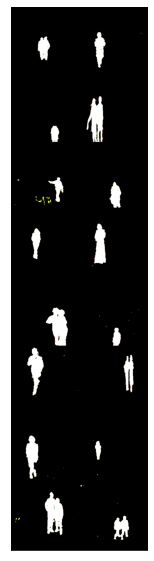

Train Epoch: 7 [750/40000 (10%)]	 Loss: 0.018961
Batch ID: 250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [900/40000 (12%)]	 Loss: 0.022012
Batch ID: 300


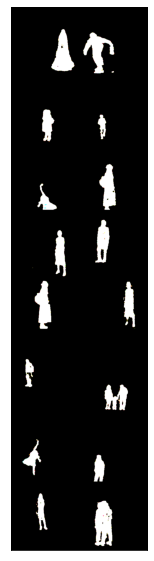

Train Epoch: 7 [1050/40000 (14%)]	 Loss: 0.024167
Batch ID: 350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [1200/40000 (16%)]	 Loss: 0.014073
Batch ID: 400


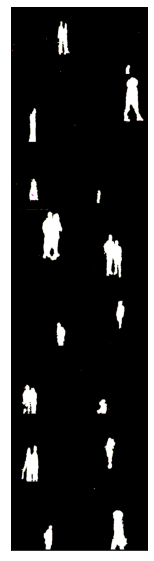

Train Epoch: 7 [1350/40000 (18%)]	 Loss: 0.019290
Batch ID: 450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [1500/40000 (20%)]	 Loss: 0.017285
Batch ID: 500


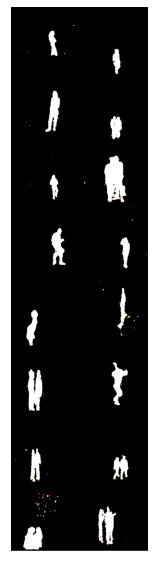

Train Epoch: 7 [1650/40000 (22%)]	 Loss: 0.017230
Batch ID: 550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [1800/40000 (24%)]	 Loss: 0.023353
Batch ID: 600


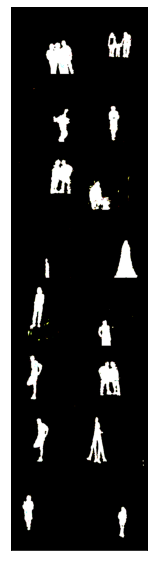

Train Epoch: 7 [1950/40000 (26%)]	 Loss: 0.017284
Batch ID: 650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [2100/40000 (28%)]	 Loss: 0.018463
Batch ID: 700


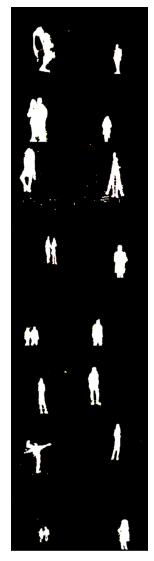

Train Epoch: 7 [2250/40000 (30%)]	 Loss: 0.018387
Batch ID: 750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [2400/40000 (32%)]	 Loss: 0.019349
Batch ID: 800


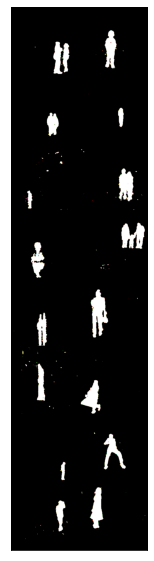

Train Epoch: 7 [2550/40000 (34%)]	 Loss: 0.020131
Batch ID: 850


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [2700/40000 (36%)]	 Loss: 0.023658
Batch ID: 900


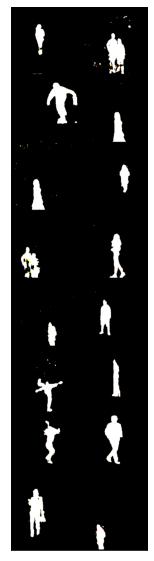

Train Epoch: 7 [2850/40000 (38%)]	 Loss: 0.019773
Batch ID: 950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [3000/40000 (40%)]	 Loss: 0.021304
Batch ID: 1000


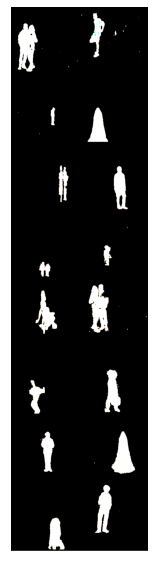

Train Epoch: 7 [3150/40000 (42%)]	 Loss: 0.021501
Batch ID: 1050


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [3300/40000 (44%)]	 Loss: 0.021321
Batch ID: 1100


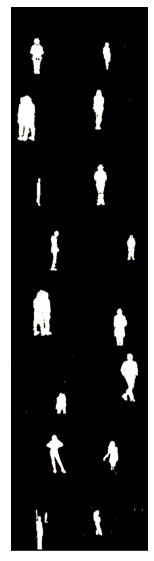

Train Epoch: 7 [3450/40000 (46%)]	 Loss: 0.027755
Batch ID: 1150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [3600/40000 (48%)]	 Loss: 0.022132
Batch ID: 1200


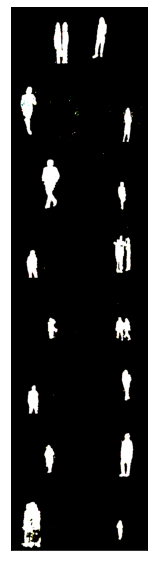

Train Epoch: 7 [3750/40000 (50%)]	 Loss: 0.021002
Batch ID: 1250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [3900/40000 (52%)]	 Loss: 0.025612
Batch ID: 1300


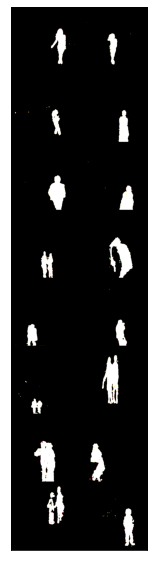

Train Epoch: 7 [4050/40000 (54%)]	 Loss: 0.019620
Batch ID: 1350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [4200/40000 (56%)]	 Loss: 0.022827
Batch ID: 1400


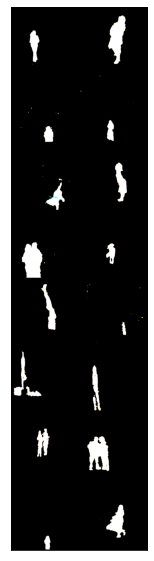

Train Epoch: 7 [4350/40000 (58%)]	 Loss: 0.026688
Batch ID: 1450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [4500/40000 (60%)]	 Loss: 0.018666
Batch ID: 1500


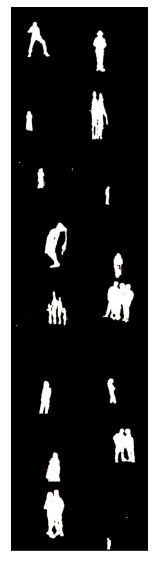

Train Epoch: 7 [4650/40000 (62%)]	 Loss: 0.014929
Batch ID: 1550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [4800/40000 (64%)]	 Loss: 0.023619
Batch ID: 1600


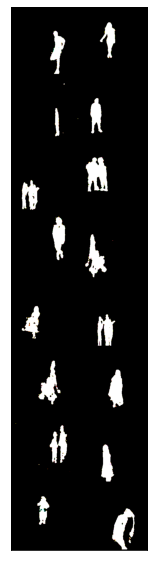

Train Epoch: 7 [4950/40000 (66%)]	 Loss: 0.016028
Batch ID: 1650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [5100/40000 (68%)]	 Loss: 0.017305
Batch ID: 1700


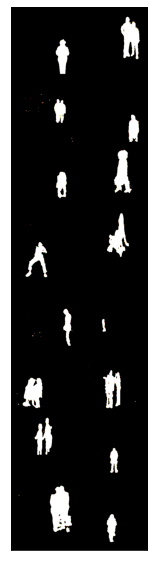

Train Epoch: 7 [5250/40000 (70%)]	 Loss: 0.019783
Batch ID: 1750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [5400/40000 (72%)]	 Loss: 0.015806
Batch ID: 1800


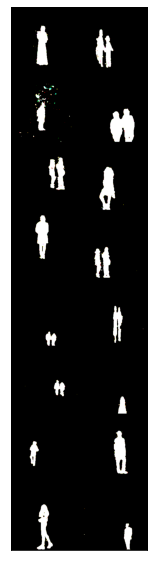

Train Epoch: 7 [5550/40000 (74%)]	 Loss: 0.021173
Batch ID: 1850


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [5700/40000 (76%)]	 Loss: 0.020814
Batch ID: 1900


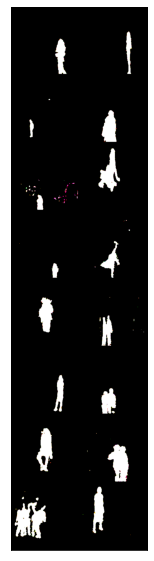

Train Epoch: 7 [5850/40000 (78%)]	 Loss: 0.019031
Batch ID: 1950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [6000/40000 (80%)]	 Loss: 0.017919
Batch ID: 2000


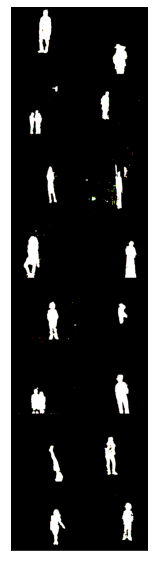

Train Epoch: 7 [6150/40000 (82%)]	 Loss: 0.022345
Batch ID: 2050


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [6300/40000 (84%)]	 Loss: 0.019270
Batch ID: 2100


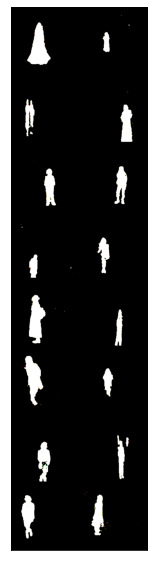

Train Epoch: 7 [6450/40000 (86%)]	 Loss: 0.019482
Batch ID: 2150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [6600/40000 (88%)]	 Loss: 0.020005
Batch ID: 2200


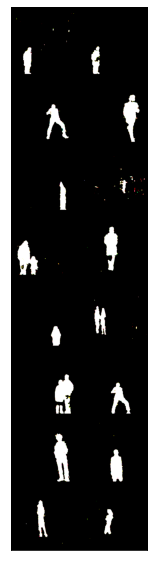

Train Epoch: 7 [6750/40000 (90%)]	 Loss: 0.025704
Batch ID: 2250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [6900/40000 (92%)]	 Loss: 0.017878
Batch ID: 2300


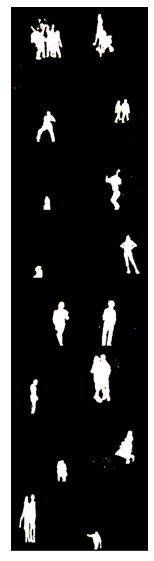

Train Epoch: 7 [7050/40000 (94%)]	 Loss: 0.021921
Batch ID: 2350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 7 [7200/40000 (96%)]	 Loss: 0.020545
Batch ID: 2400


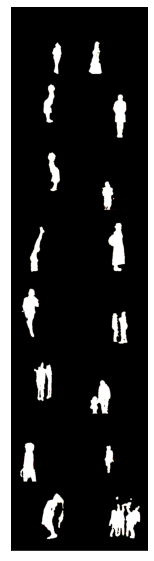

Train Epoch: 7 [7350/40000 (98%)]	 Loss: 0.018054
Batch ID: 2450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [0/40000 (0%)]	 Loss: 0.016563
Batch ID: 0


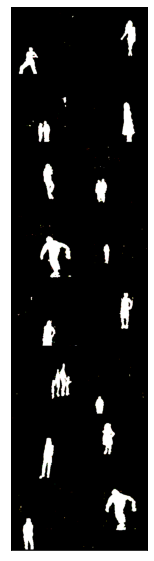

Train Epoch: 8 [150/40000 (2%)]	 Loss: 0.023220
Batch ID: 50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [300/40000 (4%)]	 Loss: 0.018508
Batch ID: 100


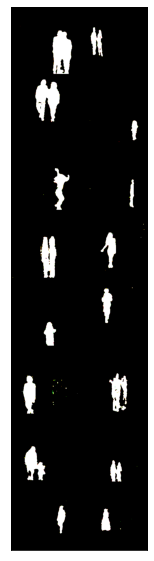

Train Epoch: 8 [450/40000 (6%)]	 Loss: 0.019248
Batch ID: 150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [600/40000 (8%)]	 Loss: 0.018631
Batch ID: 200


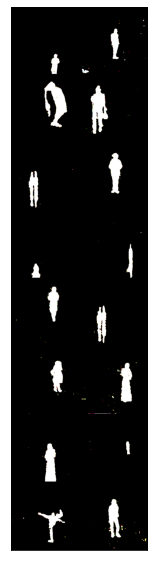

Train Epoch: 8 [750/40000 (10%)]	 Loss: 0.021464
Batch ID: 250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [900/40000 (12%)]	 Loss: 0.017557
Batch ID: 300


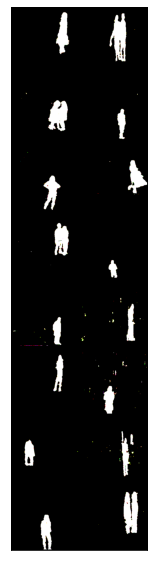

Train Epoch: 8 [1050/40000 (14%)]	 Loss: 0.015599
Batch ID: 350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [1200/40000 (16%)]	 Loss: 0.021028
Batch ID: 400


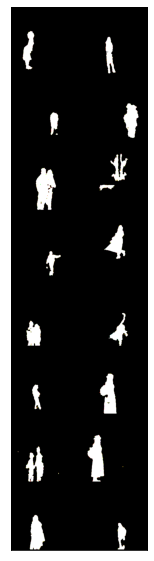

Train Epoch: 8 [1350/40000 (18%)]	 Loss: 0.025306
Batch ID: 450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [1500/40000 (20%)]	 Loss: 0.017723
Batch ID: 500


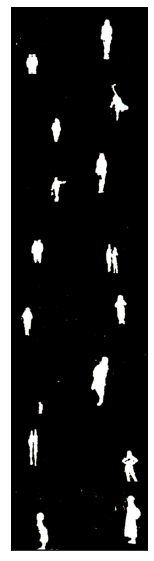

Train Epoch: 8 [1650/40000 (22%)]	 Loss: 0.019412
Batch ID: 550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [1800/40000 (24%)]	 Loss: 0.019199
Batch ID: 600


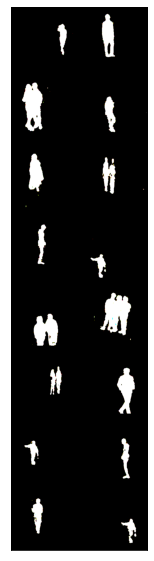

Train Epoch: 8 [1950/40000 (26%)]	 Loss: 0.020795
Batch ID: 650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [2100/40000 (28%)]	 Loss: 0.021134
Batch ID: 700


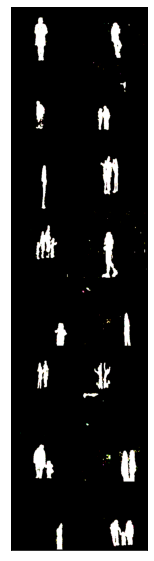

Train Epoch: 8 [2250/40000 (30%)]	 Loss: 0.017180
Batch ID: 750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [2400/40000 (32%)]	 Loss: 0.019154
Batch ID: 800


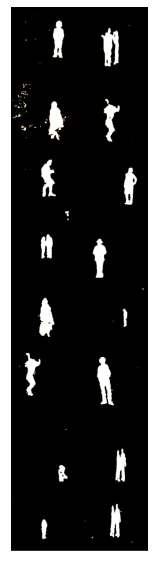

Train Epoch: 8 [2550/40000 (34%)]	 Loss: 0.022897
Batch ID: 850


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [2700/40000 (36%)]	 Loss: 0.016567
Batch ID: 900


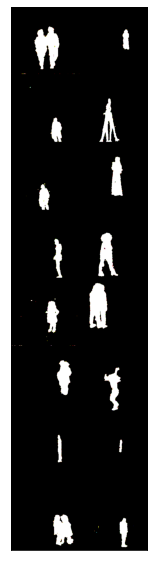

Train Epoch: 8 [2850/40000 (38%)]	 Loss: 0.018715
Batch ID: 950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [3000/40000 (40%)]	 Loss: 0.017882
Batch ID: 1000


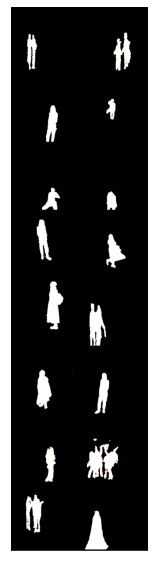

Train Epoch: 8 [3150/40000 (42%)]	 Loss: 0.016581
Batch ID: 1050


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [3300/40000 (44%)]	 Loss: 0.032623
Batch ID: 1100


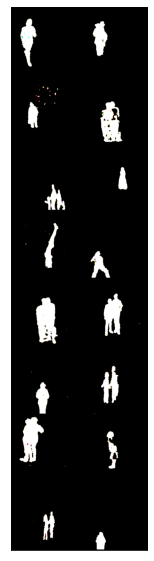

Train Epoch: 8 [3450/40000 (46%)]	 Loss: 0.020716
Batch ID: 1150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [3600/40000 (48%)]	 Loss: 0.016597
Batch ID: 1200


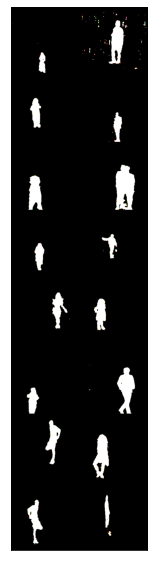

Train Epoch: 8 [3750/40000 (50%)]	 Loss: 0.016769
Batch ID: 1250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [3900/40000 (52%)]	 Loss: 0.023064
Batch ID: 1300


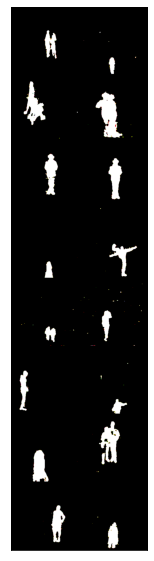

Train Epoch: 8 [4050/40000 (54%)]	 Loss: 0.019006
Batch ID: 1350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [4200/40000 (56%)]	 Loss: 0.023268
Batch ID: 1400


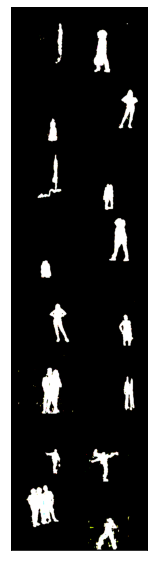

Train Epoch: 8 [4350/40000 (58%)]	 Loss: 0.021537
Batch ID: 1450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [4500/40000 (60%)]	 Loss: 0.021529
Batch ID: 1500


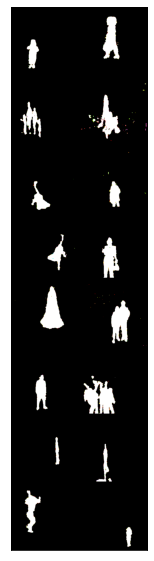

Train Epoch: 8 [4650/40000 (62%)]	 Loss: 0.019131
Batch ID: 1550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [4800/40000 (64%)]	 Loss: 0.016463
Batch ID: 1600


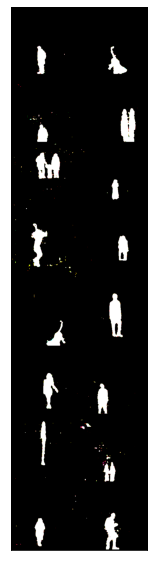

Train Epoch: 8 [4950/40000 (66%)]	 Loss: 0.020288
Batch ID: 1650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [5100/40000 (68%)]	 Loss: 0.018574
Batch ID: 1700


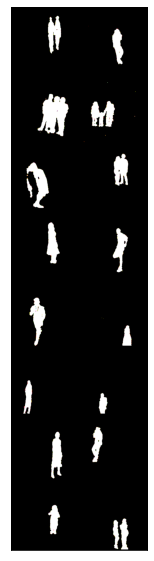

Train Epoch: 8 [5250/40000 (70%)]	 Loss: 0.020067
Batch ID: 1750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [5400/40000 (72%)]	 Loss: 0.019933
Batch ID: 1800


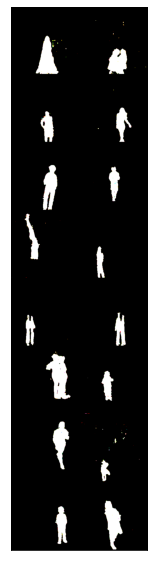

Train Epoch: 8 [5550/40000 (74%)]	 Loss: 0.014179
Batch ID: 1850


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [5700/40000 (76%)]	 Loss: 0.017876
Batch ID: 1900


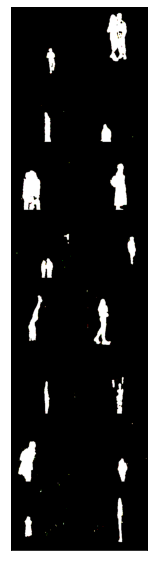

Train Epoch: 8 [5850/40000 (78%)]	 Loss: 0.022028
Batch ID: 1950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [6000/40000 (80%)]	 Loss: 0.023635
Batch ID: 2000


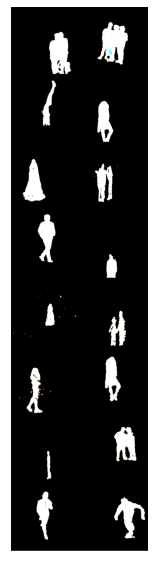

Train Epoch: 8 [6150/40000 (82%)]	 Loss: 0.021224
Batch ID: 2050


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [6300/40000 (84%)]	 Loss: 0.020122
Batch ID: 2100


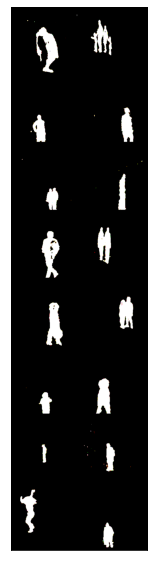

Train Epoch: 8 [6450/40000 (86%)]	 Loss: 0.025183
Batch ID: 2150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [6600/40000 (88%)]	 Loss: 0.020363
Batch ID: 2200


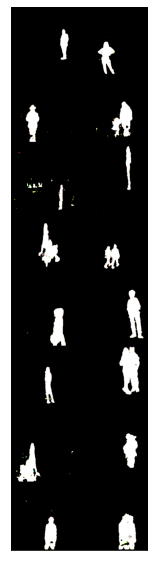

Train Epoch: 8 [6750/40000 (90%)]	 Loss: 0.017501
Batch ID: 2250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [6900/40000 (92%)]	 Loss: 0.019424
Batch ID: 2300


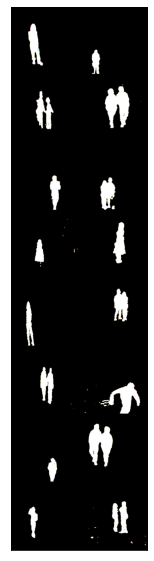

Train Epoch: 8 [7050/40000 (94%)]	 Loss: 0.017441
Batch ID: 2350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 8 [7200/40000 (96%)]	 Loss: 0.030432
Batch ID: 2400


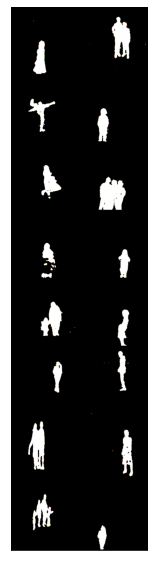

Train Epoch: 8 [7350/40000 (98%)]	 Loss: 0.019001
Batch ID: 2450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [0/40000 (0%)]	 Loss: 0.019992
Batch ID: 0


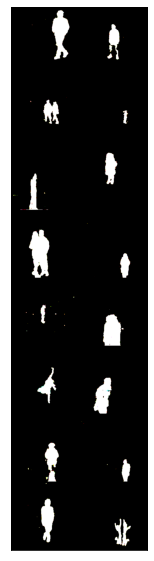

Train Epoch: 9 [150/40000 (2%)]	 Loss: 0.019762
Batch ID: 50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [300/40000 (4%)]	 Loss: 0.018621
Batch ID: 100


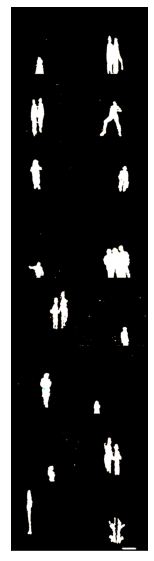

Train Epoch: 9 [450/40000 (6%)]	 Loss: 0.016195
Batch ID: 150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [600/40000 (8%)]	 Loss: 0.022289
Batch ID: 200


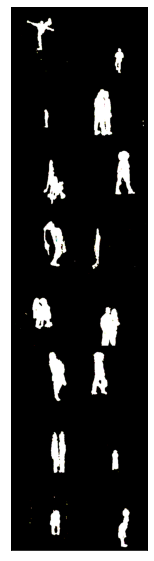

Train Epoch: 9 [750/40000 (10%)]	 Loss: 0.021985
Batch ID: 250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [900/40000 (12%)]	 Loss: 0.026113
Batch ID: 300


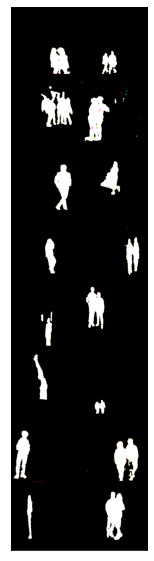

Train Epoch: 9 [1050/40000 (14%)]	 Loss: 0.023448
Batch ID: 350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [1200/40000 (16%)]	 Loss: 0.017774
Batch ID: 400


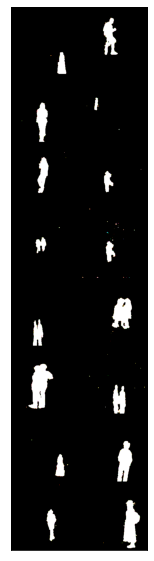

Train Epoch: 9 [1350/40000 (18%)]	 Loss: 0.022637
Batch ID: 450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [1500/40000 (20%)]	 Loss: 0.019352
Batch ID: 500


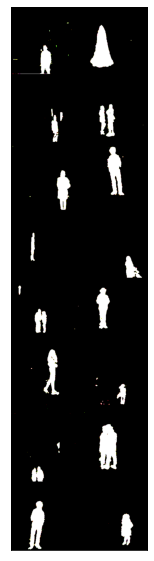

Train Epoch: 9 [1650/40000 (22%)]	 Loss: 0.019591
Batch ID: 550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [1800/40000 (24%)]	 Loss: 0.022642
Batch ID: 600


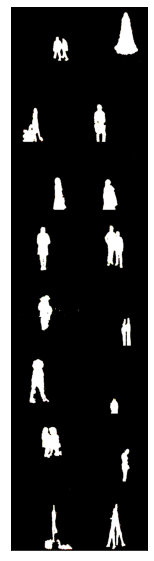

Train Epoch: 9 [1950/40000 (26%)]	 Loss: 0.021118
Batch ID: 650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [2100/40000 (28%)]	 Loss: 0.015310
Batch ID: 700


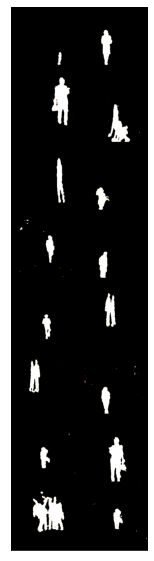

Train Epoch: 9 [2250/40000 (30%)]	 Loss: 0.020916
Batch ID: 750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [2400/40000 (32%)]	 Loss: 0.016526
Batch ID: 800


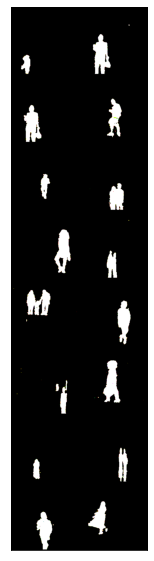

Train Epoch: 9 [2550/40000 (34%)]	 Loss: 0.018584
Batch ID: 850


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [2700/40000 (36%)]	 Loss: 0.020545
Batch ID: 900


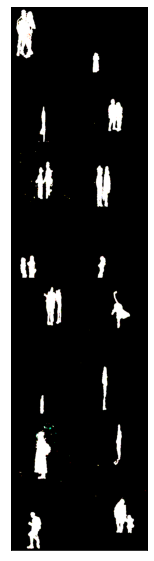

Train Epoch: 9 [2850/40000 (38%)]	 Loss: 0.020307
Batch ID: 950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [3000/40000 (40%)]	 Loss: 0.020344
Batch ID: 1000


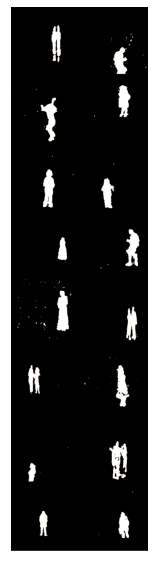

Train Epoch: 9 [3150/40000 (42%)]	 Loss: 0.022320
Batch ID: 1050


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [3300/40000 (44%)]	 Loss: 0.017715
Batch ID: 1100


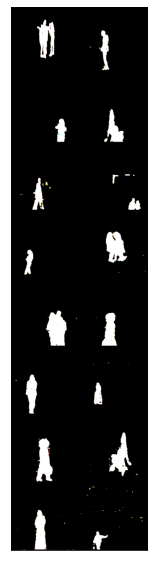

Train Epoch: 9 [3450/40000 (46%)]	 Loss: 0.017321
Batch ID: 1150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [3600/40000 (48%)]	 Loss: 0.019472
Batch ID: 1200


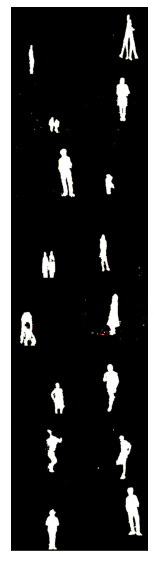

Train Epoch: 9 [3750/40000 (50%)]	 Loss: 0.018131
Batch ID: 1250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [3900/40000 (52%)]	 Loss: 0.017900
Batch ID: 1300


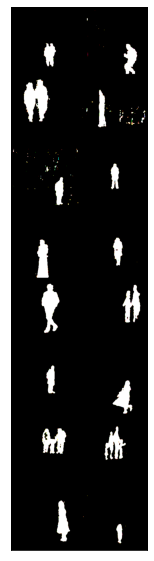

Train Epoch: 9 [4050/40000 (54%)]	 Loss: 0.021934
Batch ID: 1350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [4200/40000 (56%)]	 Loss: 0.017499
Batch ID: 1400


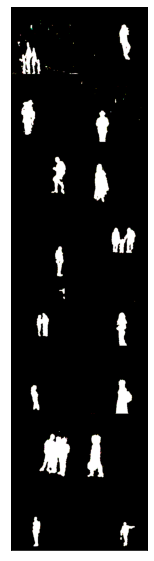

Train Epoch: 9 [4350/40000 (58%)]	 Loss: 0.017789
Batch ID: 1450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [4500/40000 (60%)]	 Loss: 0.023401
Batch ID: 1500


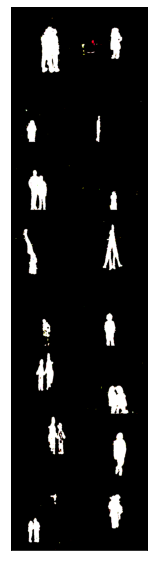

Train Epoch: 9 [4650/40000 (62%)]	 Loss: 0.022290
Batch ID: 1550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [4800/40000 (64%)]	 Loss: 0.017706
Batch ID: 1600


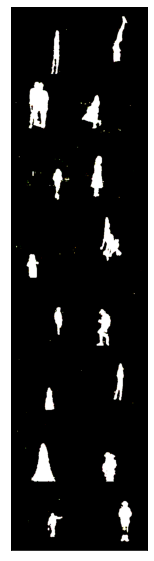

Train Epoch: 9 [4950/40000 (66%)]	 Loss: 0.017257
Batch ID: 1650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [5100/40000 (68%)]	 Loss: 0.023417
Batch ID: 1700


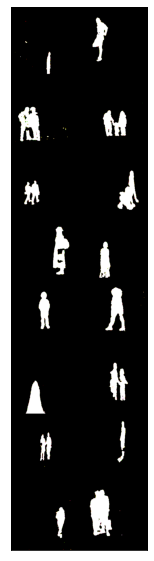

Train Epoch: 9 [5250/40000 (70%)]	 Loss: 0.018946
Batch ID: 1750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [5400/40000 (72%)]	 Loss: 0.022098
Batch ID: 1800


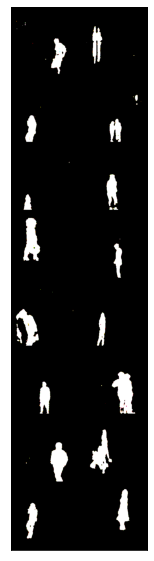

Train Epoch: 9 [5550/40000 (74%)]	 Loss: 0.026167
Batch ID: 1850


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [5700/40000 (76%)]	 Loss: 0.019997
Batch ID: 1900


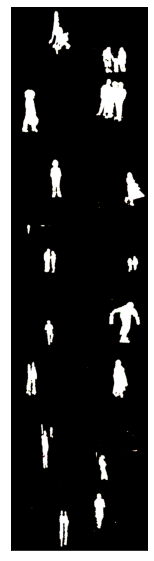

Train Epoch: 9 [5850/40000 (78%)]	 Loss: 0.021052
Batch ID: 1950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [6000/40000 (80%)]	 Loss: 0.024245
Batch ID: 2000


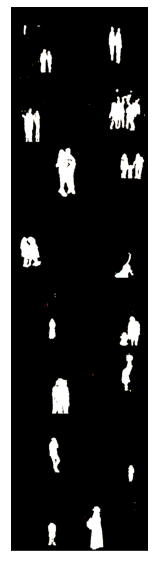

Train Epoch: 9 [6150/40000 (82%)]	 Loss: 0.021984
Batch ID: 2050


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [6300/40000 (84%)]	 Loss: 0.014822
Batch ID: 2100


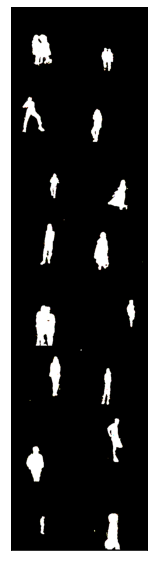

Train Epoch: 9 [6450/40000 (86%)]	 Loss: 0.019137
Batch ID: 2150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [6600/40000 (88%)]	 Loss: 0.027778
Batch ID: 2200


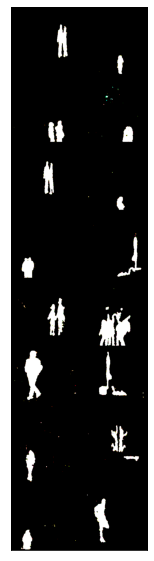

Train Epoch: 9 [6750/40000 (90%)]	 Loss: 0.017596
Batch ID: 2250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [6900/40000 (92%)]	 Loss: 0.021472
Batch ID: 2300


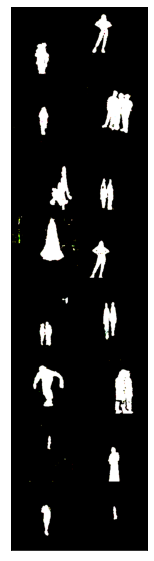

Train Epoch: 9 [7050/40000 (94%)]	 Loss: 0.027487
Batch ID: 2350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 9 [7200/40000 (96%)]	 Loss: 0.017582
Batch ID: 2400


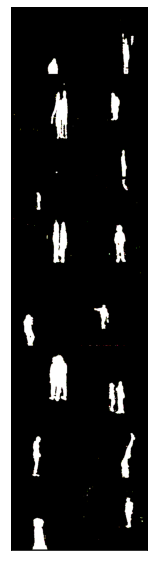

Train Epoch: 9 [7350/40000 (98%)]	 Loss: 0.017246
Batch ID: 2450


In [35]:
optim = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9, weight_decay=1e-5)

from torch.optim.lr_scheduler import StepLR

device = torch.device('cuda:0')
# device = torch.device('cpu')
model = model.to(device)

scheduler = StepLR(optim, step_size=1, gamma=0.01)
train(model, criterion, device, train_loader, optim, 1)
for epoch in range(1, 10):
    train(model, criterion, device, train_loader, optim, epoch)
    #test(model, device, test Loader)
    scheduler.step()